# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

- **id**: id univoco dell'acquirente.

- **Gender**: sesso dell'acquirente.

- **Age**: età dell'acquirente.

- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.

- **Region_Code**: codice univoco della regione dell'acquirente.

- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.

- **Vehicle_Age**: età del veicolo

- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.

- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.

- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)

- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.

- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response**.


[LINK AL DATASET (Richiede un'account su Kaggle)](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

In [2]:
SEED = 1 # set the seed for reproducibility

### Import datasets

In [3]:
df_train = pd.read_csv("train.csv")
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
dataset_test = pd.read_csv("test.csv")
dataset_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


### Exploratory Data Analysis

In [5]:
df_train.shape

(381109, 12)

In [6]:
dataset_test.shape

(127037, 11)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [8]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


In [9]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [10]:
dataset_test.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000


In [11]:
df_train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [12]:
dataset_test.nunique()

id                      127037
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           36327
Policy_Sales_Channel       145
Vintage                    290
dtype: int64

#### Check any na values

In [13]:
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [14]:
dataset_test.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [15]:
df_train.drop(columns = "id", inplace = True)
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [16]:
df_train.shape

(381109, 11)

#### Descriptive analysis

In [17]:
# set the theme and size of the charts
plt.rcParams["figure.figsize"] = (16,10)
sns.set_theme(palette="dark")

##### Response

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Response', ylabel='count'>

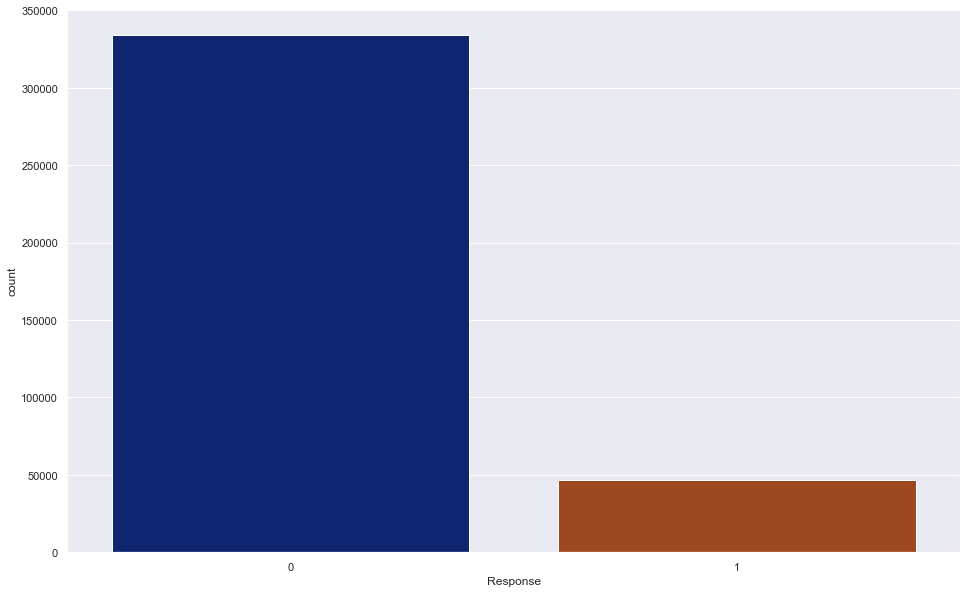

In [18]:
sns.countplot(df_train['Response'],data=df_train)

In [19]:
counts = df_train["Response"].value_counts()
print(f"No = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"Yes = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

No = 334399 (87.74%)
Yes = 46710 (12.26%)


##### Annual_Premium

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

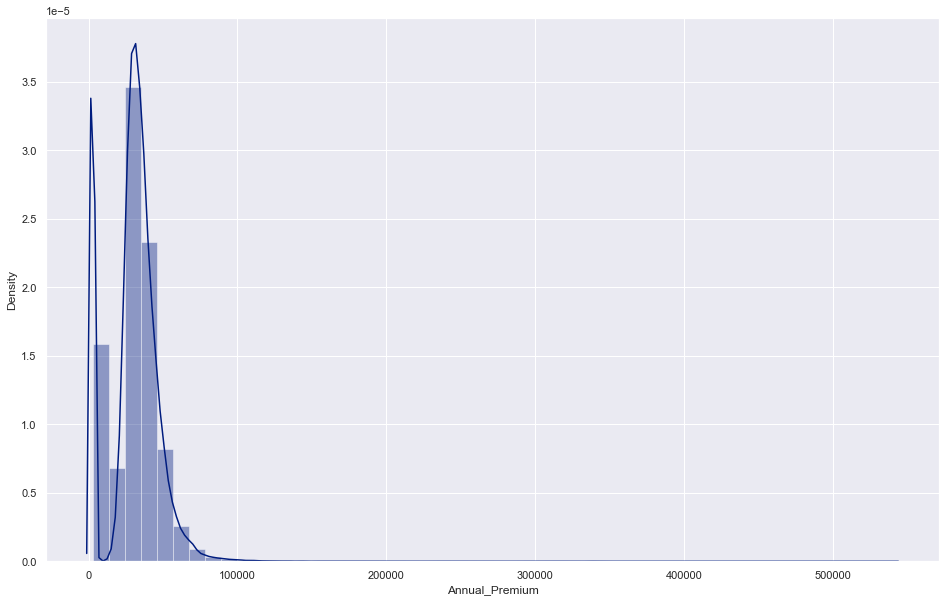

In [20]:
sns.distplot(df_train['Annual_Premium'])

From the graph above we can deduce that the annual premium has a positively skewed distribution.

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Annual_Premium'>

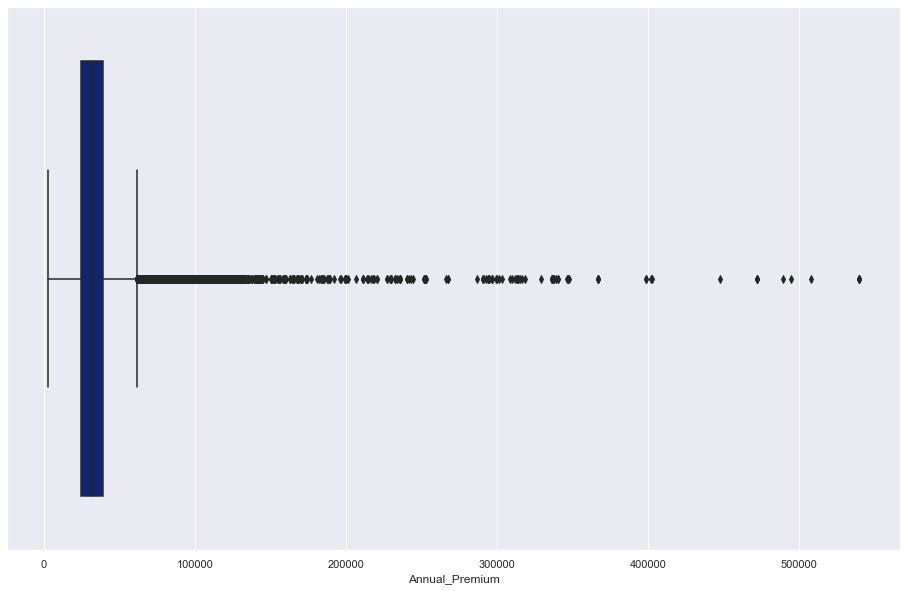

In [21]:
sns.boxplot(df_train['Annual_Premium'])

In [22]:
df_train['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [23]:
df_train['Annual_Premium'].value_counts()

2630.0     64877
69856.0      140
39008.0       41
38287.0       38
45179.0       38
           ...  
54253.0        1
81339.0        1
65248.0        1
60162.0        1
40880.0        1
Name: Annual_Premium, Length: 48838, dtype: int64

##### Age

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

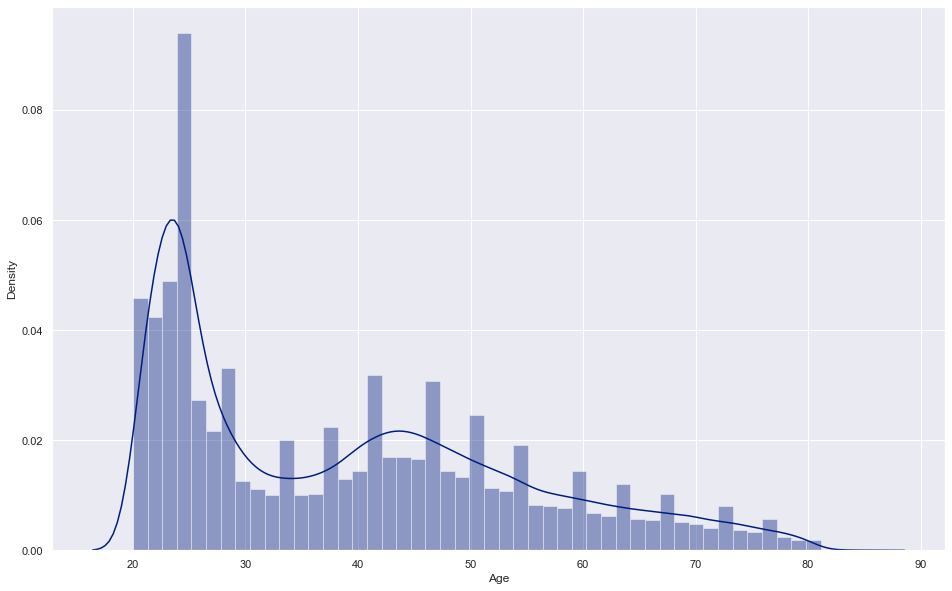

In [24]:
sns.distplot(df_train['Age'])

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

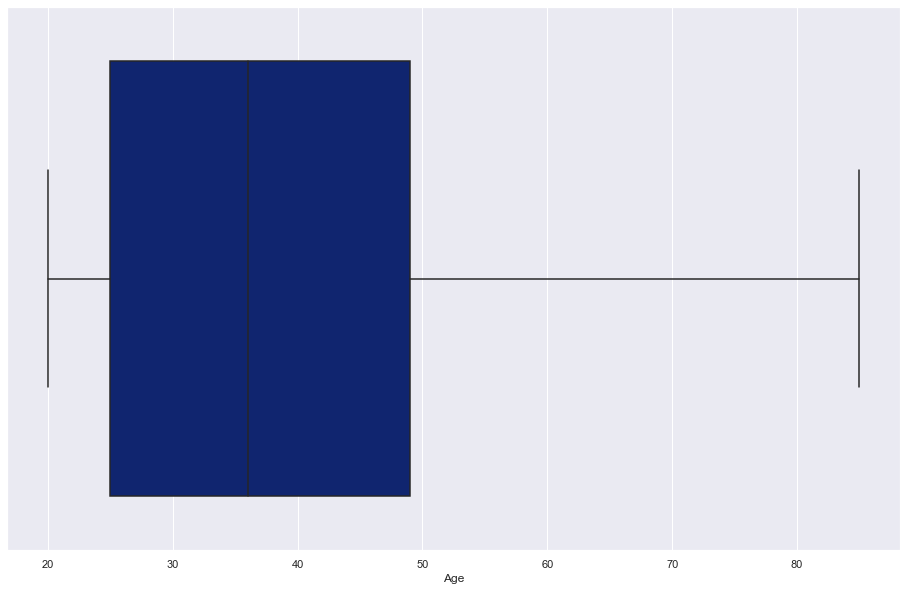

In [25]:
sns.boxplot(df_train['Age'])

In [26]:
df_train['Age'].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

In [27]:
df_train['Age'].value_counts()

24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: Age, Length: 66, dtype: int64

##### Vintage

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Vintage', ylabel='Density'>

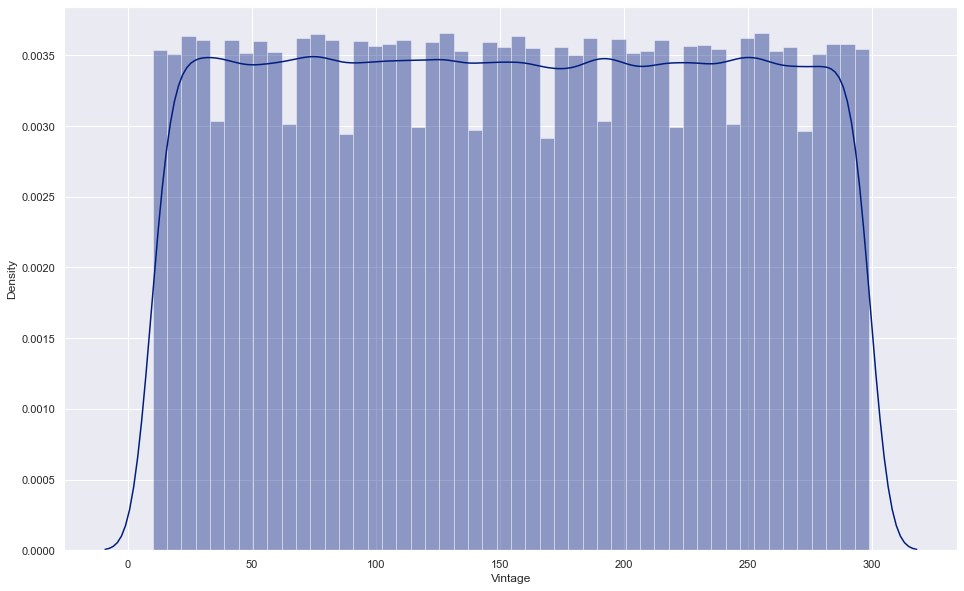

In [28]:
sns.distplot(df_train['Vintage'])

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vintage'>

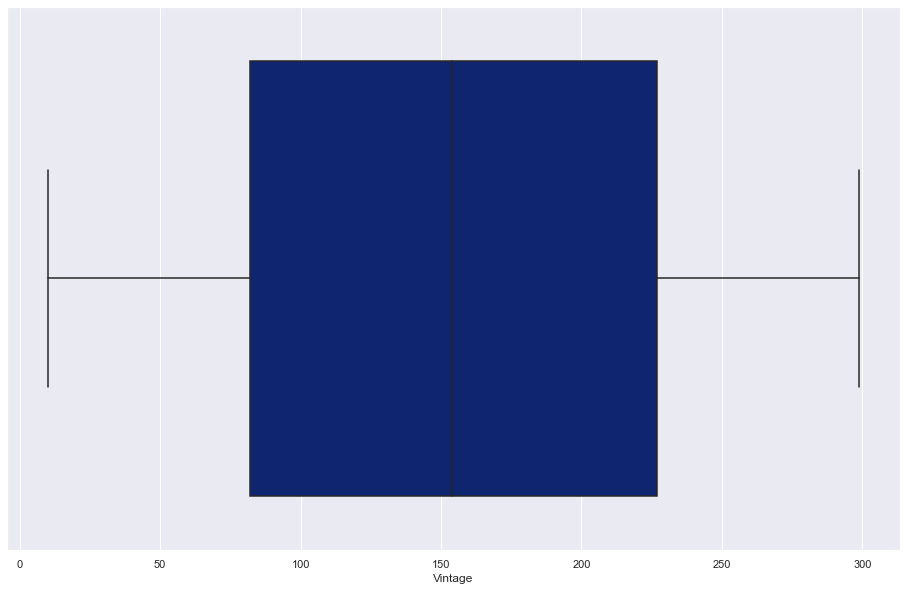

In [29]:
sns.boxplot(df_train['Vintage'])

In [30]:
df_train['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

##### Gender

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Gender', ylabel='count'>

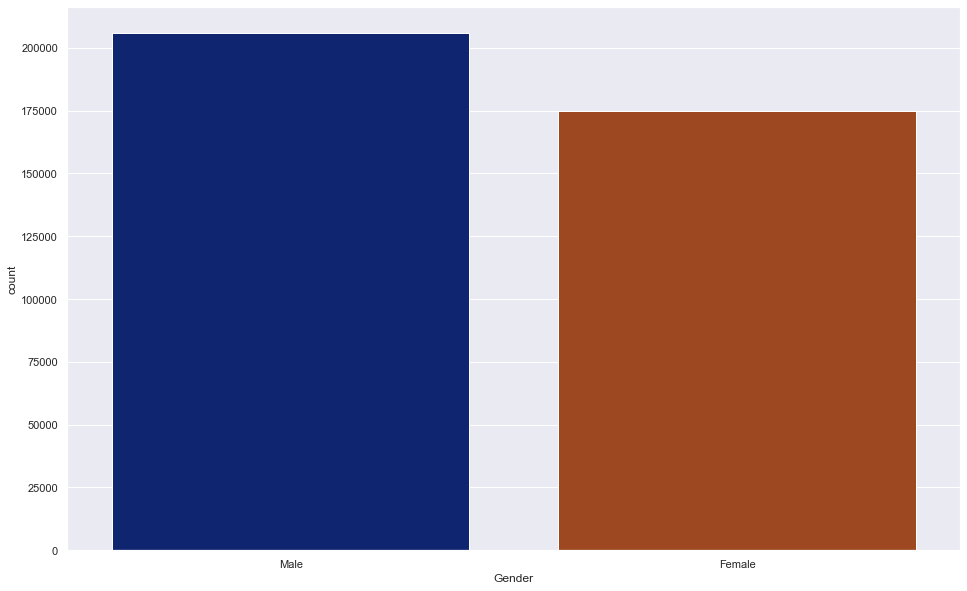

In [31]:
sns.countplot(df_train['Gender'],data=df_train)

In [32]:
df_train['Gender'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [33]:
counts = df_train["Gender"].value_counts()
print(f"Male = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"Female = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

Male = 206089 (54.08%)
Female = 175020 (45.92%)


##### Driving_License

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Driving_License', ylabel='count'>

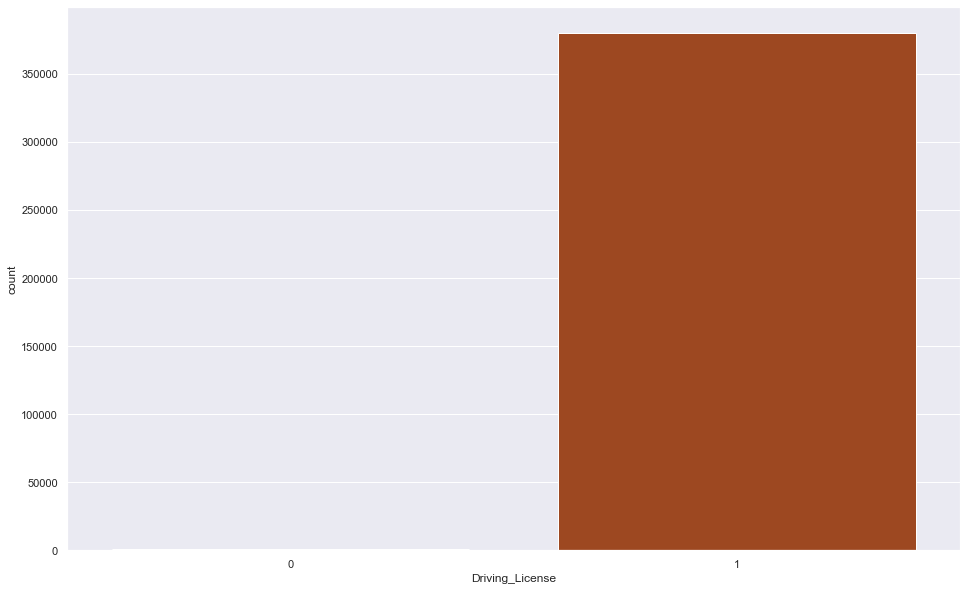

In [34]:
sns.countplot(df_train['Driving_License'],data=df_train)

In [35]:
df_train['Driving_License'].value_counts()

1    380297
0       812
Name: Driving_License, dtype: int64

In [36]:
counts = df_train["Driving_License"].value_counts()
print(f"No = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"Yes = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

No = 812 (0.21%)
Yes = 380297 (99.79%)


##### Previously_Insured

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

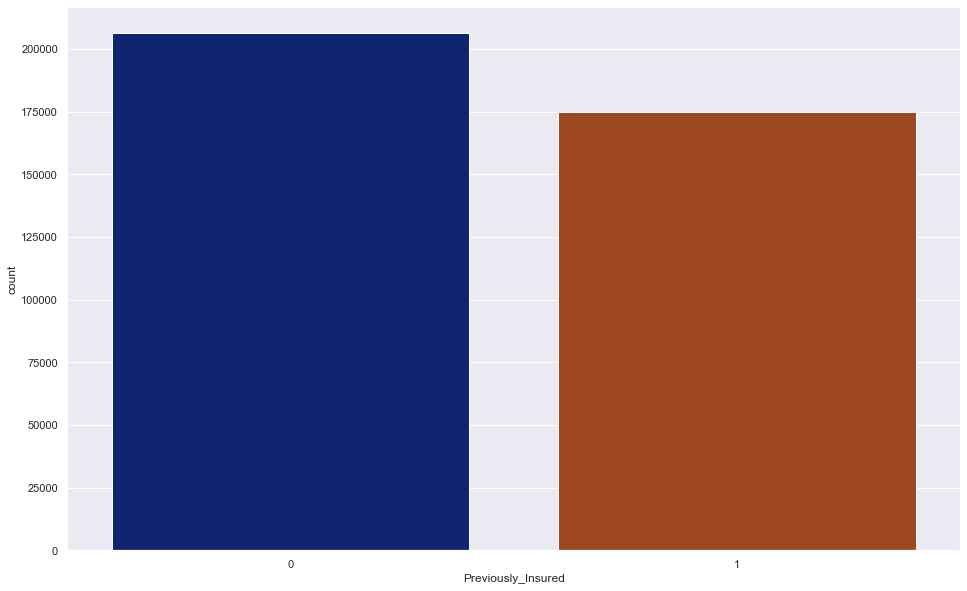

In [37]:
sns.countplot(df_train['Previously_Insured'],data=df_train)

In [38]:
df_train['Previously_Insured'].value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

In [39]:
counts = df_train["Previously_Insured"].value_counts()
print(f"No = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"Yes = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

No = 206481 (54.18%)
Yes = 174628 (45.82%)


##### Vehicle_Age

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

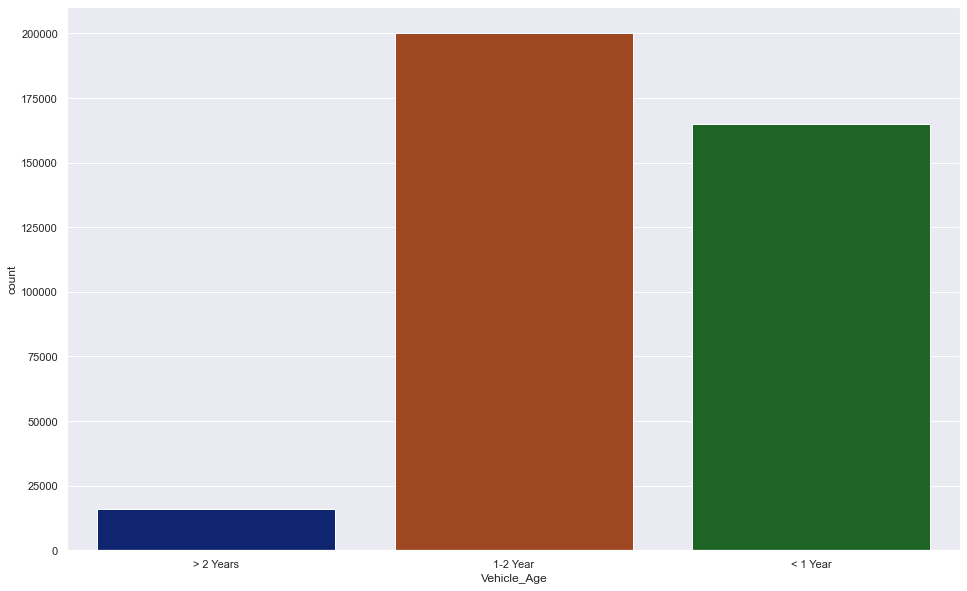

In [40]:
sns.countplot(df_train["Vehicle_Age"],data=df_train)

In [41]:
df_train["Vehicle_Age"].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [42]:
counts = df_train["Vehicle_Age"].value_counts()
print(f"1-2 Year = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"< 1 Year = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")
print(f"> 2 Years = {counts[2]} ({counts[2]/counts.sum()*100:.2f}%)")

1-2 Year = 200316 (52.56%)
< 1 Year = 164786 (43.24%)
> 2 Years = 16007 (4.20%)


##### Vehicle_Damage

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

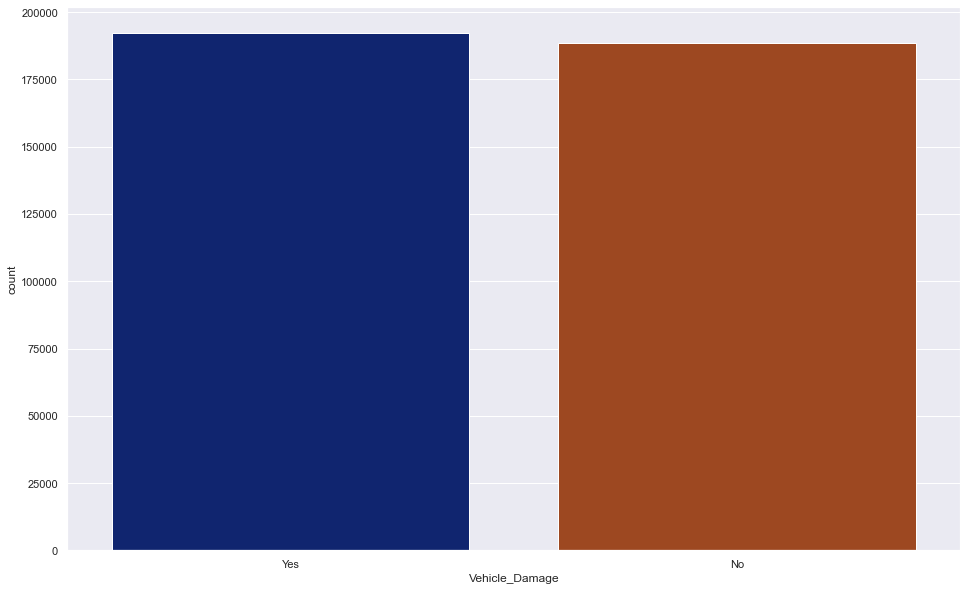

In [43]:
sns.countplot(df_train["Vehicle_Damage"],data=df_train)

In [44]:
df_train["Vehicle_Damage"].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [45]:
counts = df_train["Vehicle_Damage"].value_counts()
print(f"Yes = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"No = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

Yes = 192413 (50.49%)
No = 188696 (49.51%)


##### Region_Code

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Region_Code', ylabel='count'>

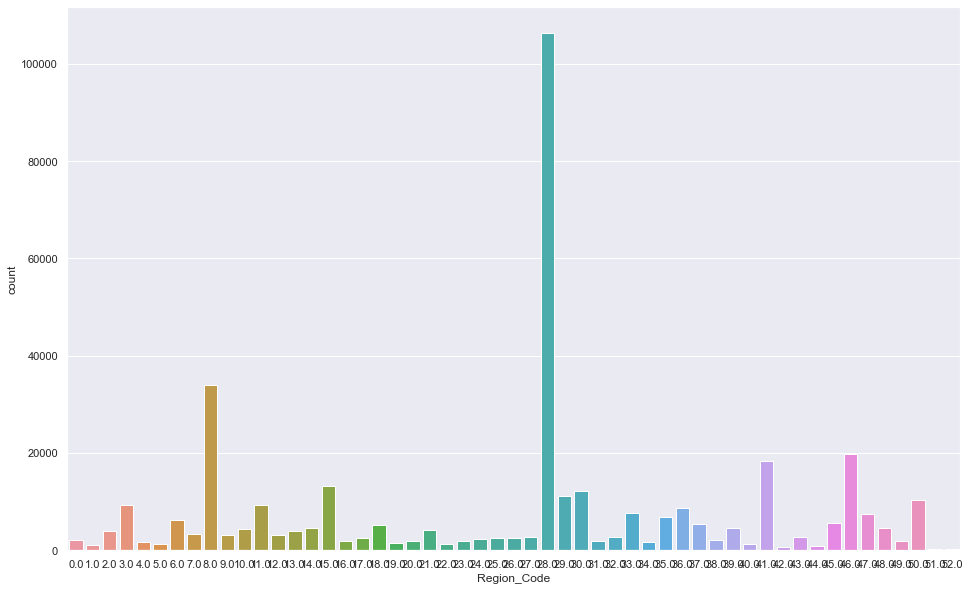

In [46]:
sns.countplot(df_train["Region_Code"],data=df_train)

In [47]:
df_train["Region_Code"].value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

##### Policy_Sales_Channel

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='count'>

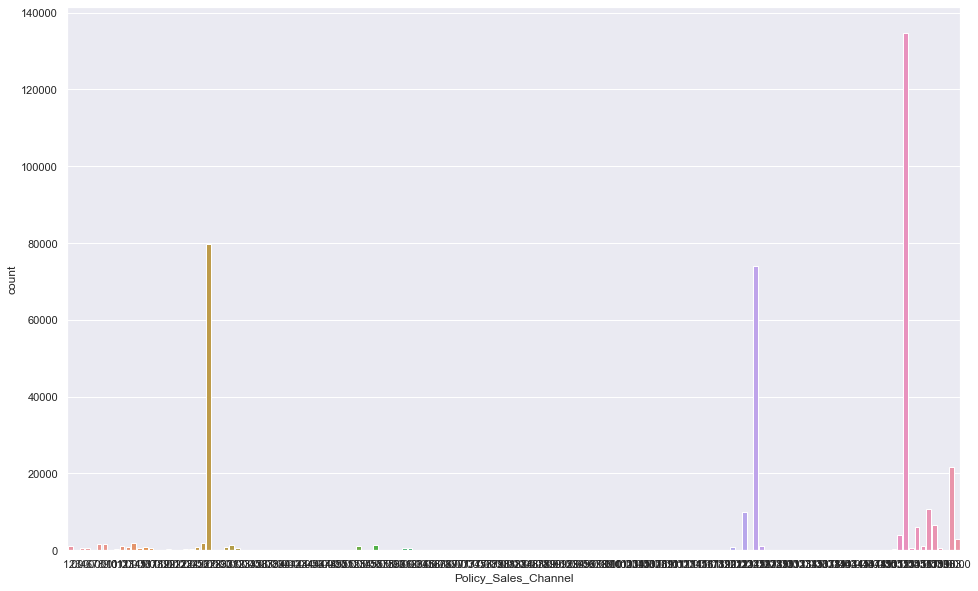

In [48]:
sns.countplot(df_train["Policy_Sales_Channel"],data=df_train)

In [49]:
df_train["Policy_Sales_Channel"].value_counts()

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
143.0         1
43.0          1
41.0          1
84.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

##### Age and Response

<AxesSubplot:xlabel='Age', ylabel='Density'>

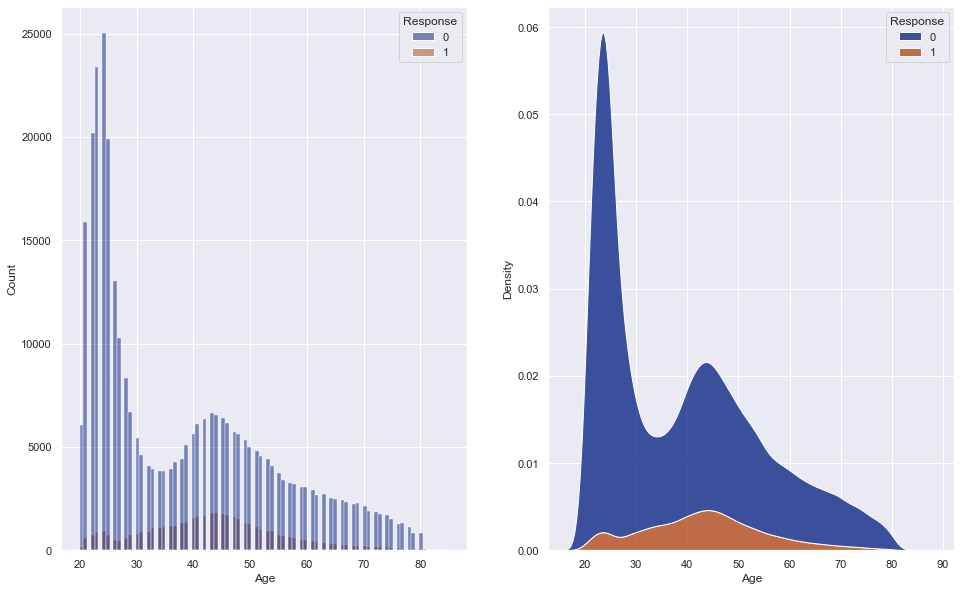

In [50]:
plt.subplot(1, 2, 1)
sns.histplot(x="Age", data=df_train, hue="Response")

plt.subplot(1, 2, 2)
sns.kdeplot(x="Age", data=df_train, hue="Response", multiple="stack")

Text(0.5, 1.0, 'Correlation between Age and Response')

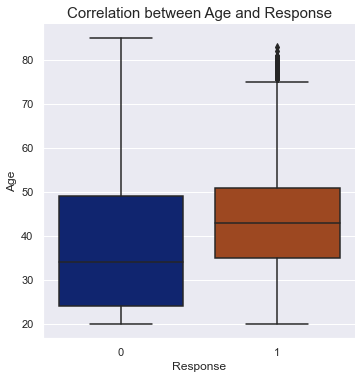

In [51]:
sns.catplot(x="Response", 
            y="Age", 
            data=df_train, 
            kind="box")
plt.title("Correlation between Age and Response", size=15, y=1.0)

##### Vintage and Response

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

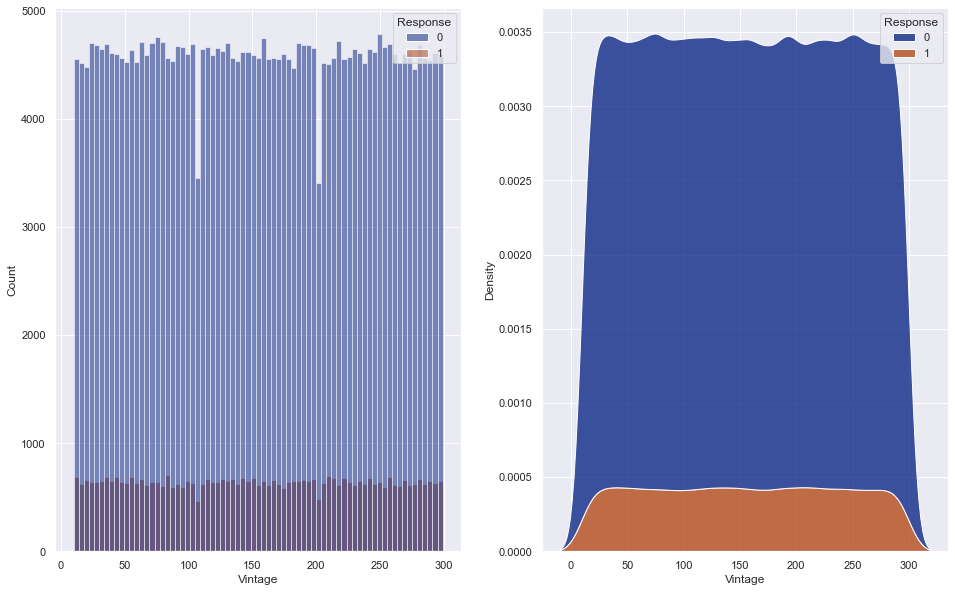

In [52]:
plt.subplot(1, 2, 1)
sns.histplot(x="Vintage", data=df_train, hue="Response")

plt.subplot(1, 2, 2)
sns.kdeplot(x="Vintage", data=df_train, hue="Response", multiple="stack")

Text(0.5, 1.0, 'Correlation between Vintage code and Response')

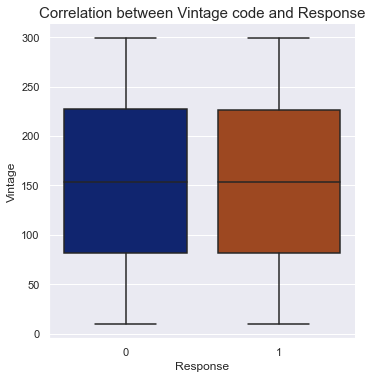

In [53]:
sns.catplot(x="Response", 
            y="Vintage", 
            data=df_train, 
            kind="box")
plt.title("Correlation between Vintage code and Response", size=15, y=1.0)

##### Annual Premium and Response

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

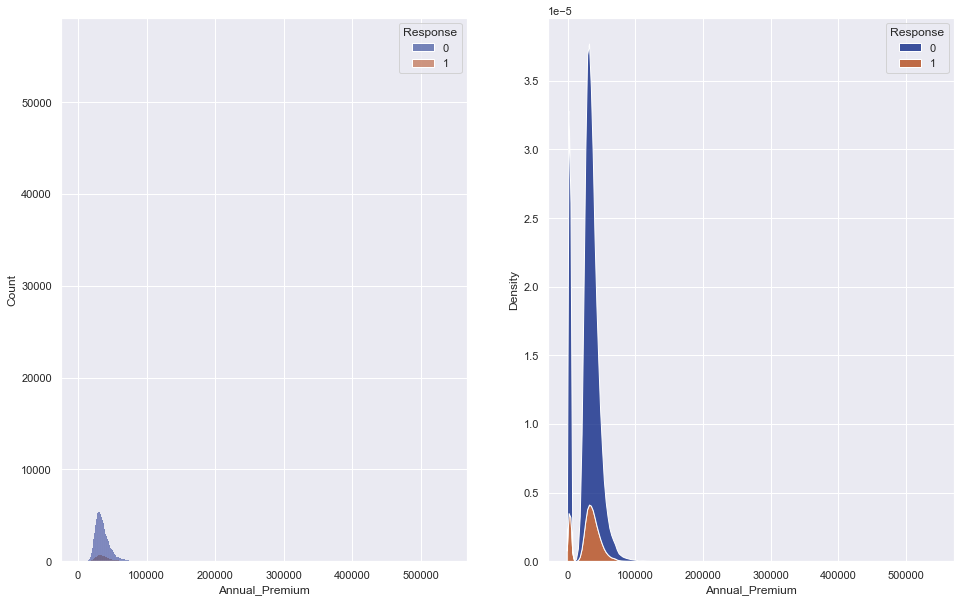

In [54]:
plt.subplot(1, 2, 1)
sns.histplot(x="Annual_Premium", data=df_train, hue="Response")

plt.subplot(1, 2, 2)
sns.kdeplot(x="Annual_Premium", data=df_train, hue="Response", multiple="stack")

Text(0.5, 1.0, 'Correlation between Annual_Premium and Response')

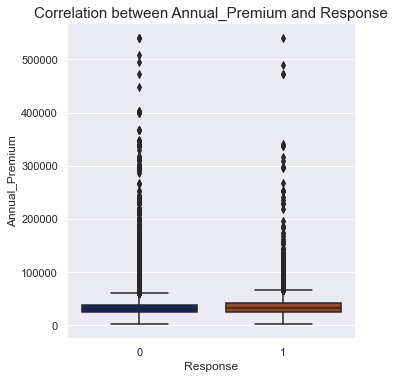

In [55]:
sns.catplot(x="Response", 
            y="Annual_Premium", 
            data=df_train, 
            kind="box")
plt.title("Correlation between Annual_Premium and Response", size=15, y=1.0)

##### Vehicle Age and Response

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Count'>

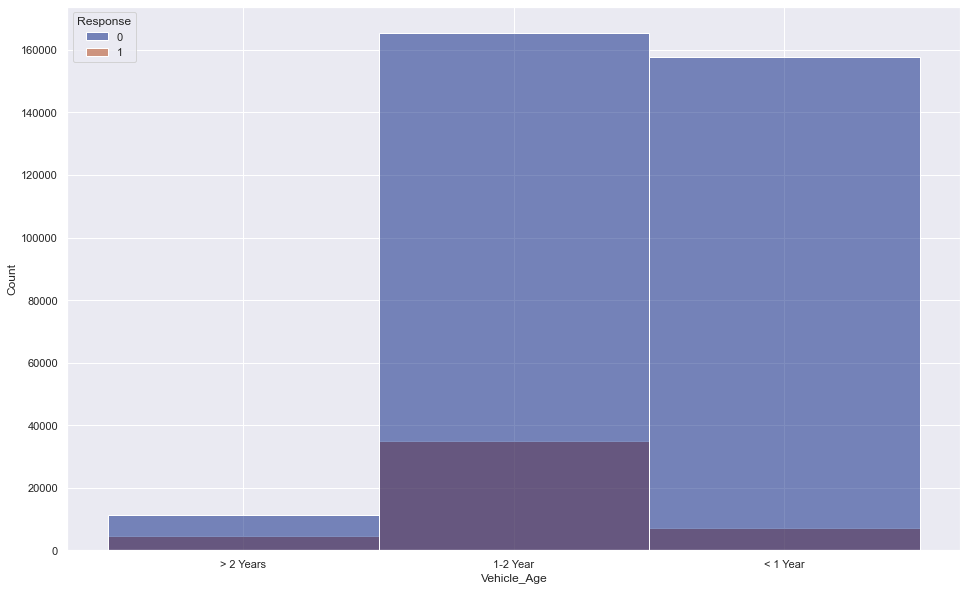

In [56]:
sns.histplot(x="Vehicle_Age", data=df_train, hue="Response")

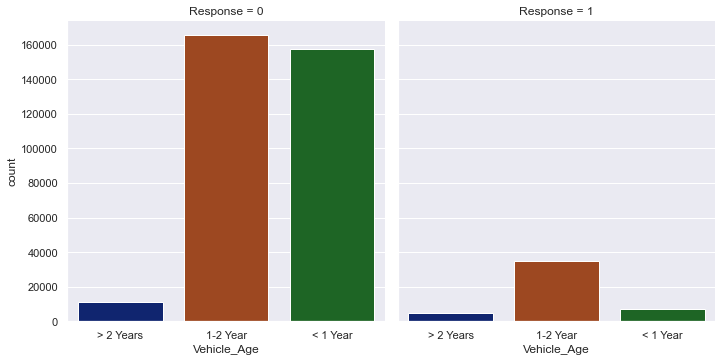

In [57]:
sns.catplot(x="Vehicle_Age", 
            col="Response", 
            data=df_train, 
            kind="count")

In [58]:
df_train.groupby(["Vehicle_Age", "Response"]).size().unstack()

Response,0,1
Vehicle_Age,,
1-2 Year,165510,34806
< 1 Year,157584,7202
> 2 Years,11305,4702


##### Vehicle Damage and Response

Text(0.5, 1.0, 'Correlation between Vehicle_Damage and Response ')

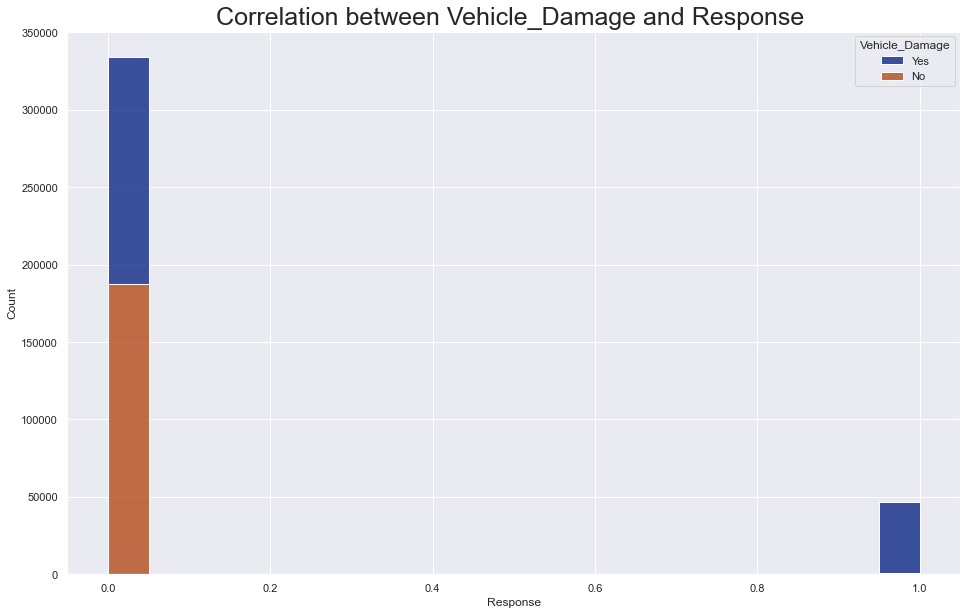

In [59]:
sns.histplot(data = df_train,
            x = "Response",
            hue = "Vehicle_Damage",
            multiple="stack")
plt.title("Correlation between Vehicle_Damage and Response ", size=25, y=1.0)

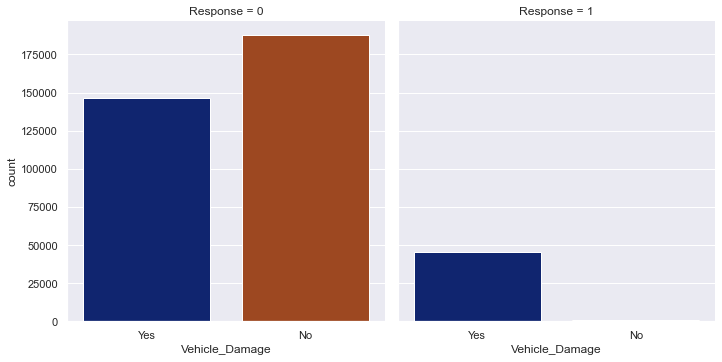

In [60]:
sns.catplot(x="Vehicle_Damage", 
            col="Response", 
            data=df_train, 
            kind="count")

In [61]:
df_train.groupby(["Vehicle_Damage", "Response"]).size().unstack()

Response,0,1
Vehicle_Damage,,
No,187714,982
Yes,146685,45728


##### Previously Insured and Response

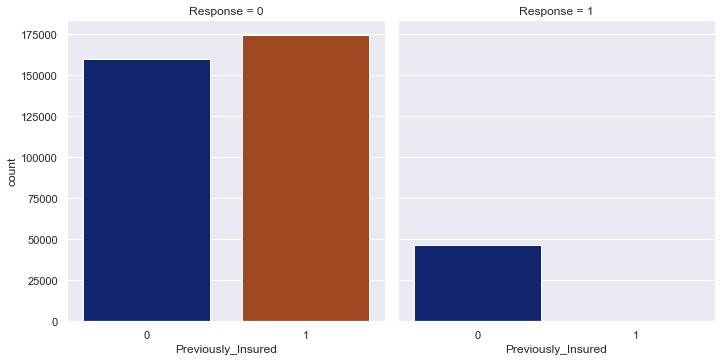

In [62]:
sns.catplot(x="Previously_Insured", 
            col="Response", 
            data=df_train, 
            kind="count")

In [63]:
df_train.groupby(["Previously_Insured", "Response"]).size().unstack()

Response,0,1
Previously_Insured,,
0,159929,46552
1,174470,158


##### Policy Sales Channel and Response

<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='Density'>

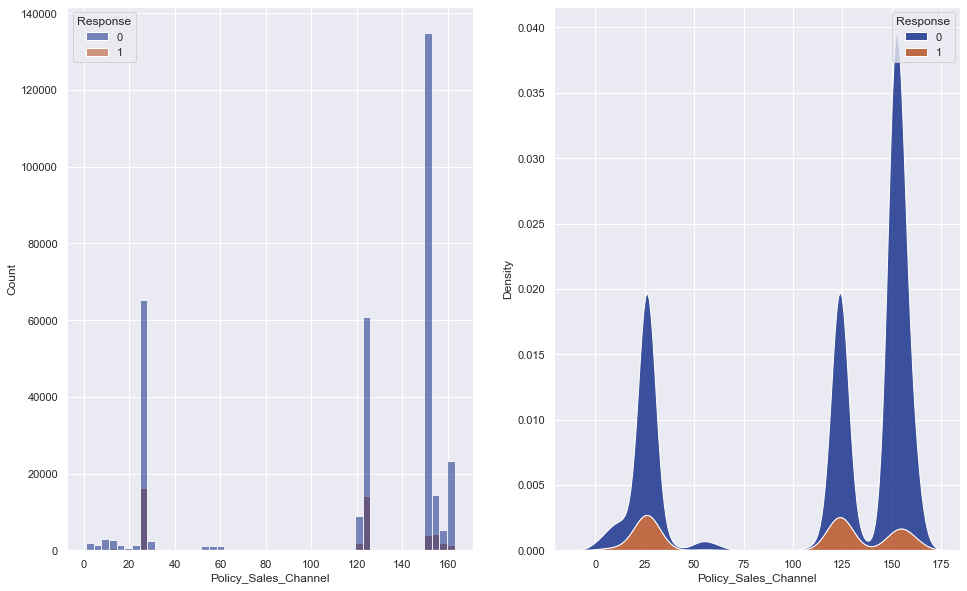

In [64]:
plt.subplot(1, 2, 1)
sns.histplot(x="Policy_Sales_Channel", data=df_train, hue="Response")

plt.subplot(1, 2, 2)
sns.kdeplot(x="Policy_Sales_Channel", data=df_train, hue="Response", multiple="stack")

##### Gender and Response

Text(0.5, 1.0, 'Correlation between Gender and Response ')

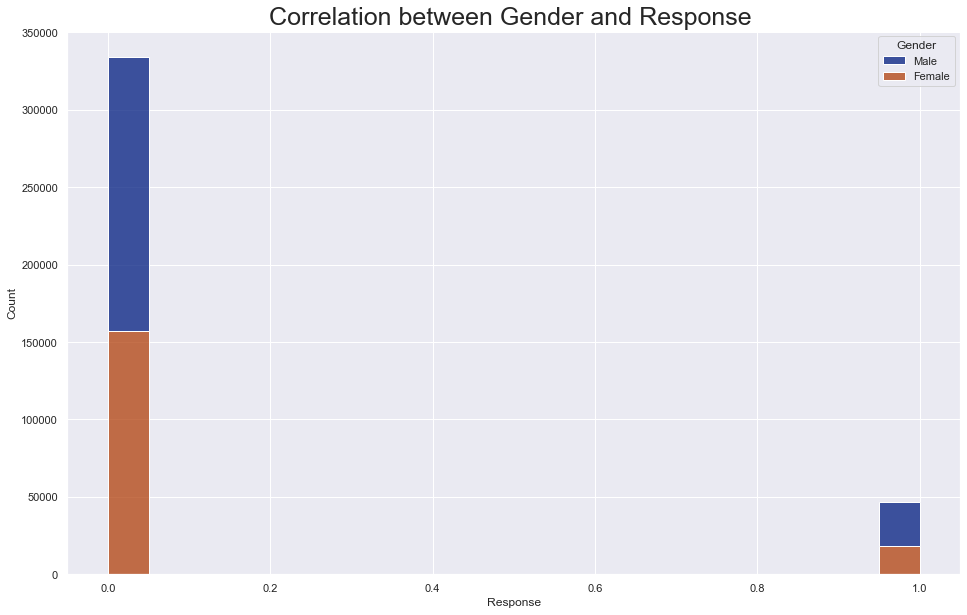

In [65]:
sns.histplot(data = df_train,
            x = "Response",
            hue = "Gender",
            multiple="stack")
plt.title("Correlation between Gender and Response ", size=25, y=1.0)

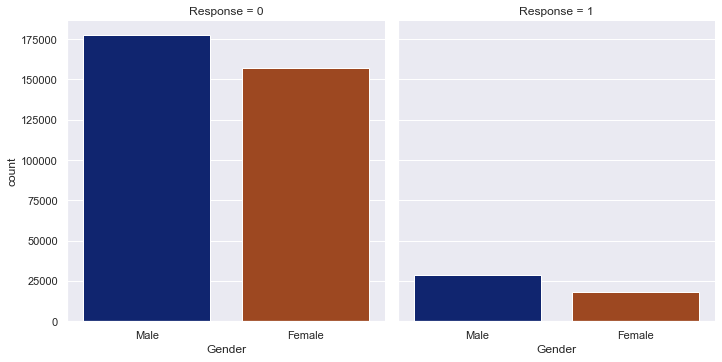

In [66]:
sns.catplot(x="Gender", 
            col="Response", 
            data=df_train, 
            kind="count")

In [67]:
df_train.groupby(["Gender", "Response"]).size().unstack()

Response,0,1
Gender,,
Female,156835,18185
Male,177564,28525


##### Driving License and Response

Text(0.5, 1.0, 'Correlation between Driving License and Response ')

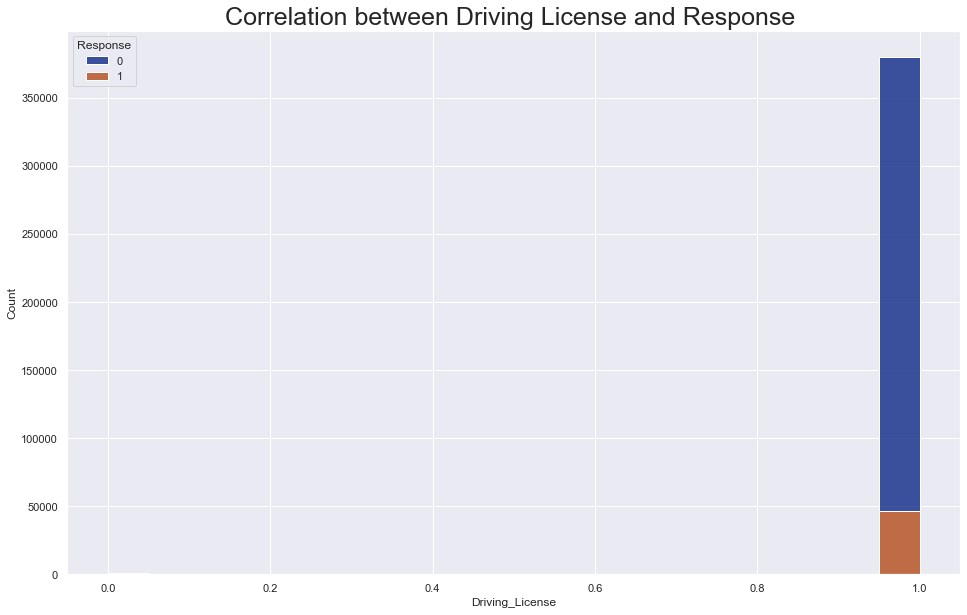

In [68]:
sns.histplot(data = df_train,
            x = "Driving_License",
            hue = "Response",
            multiple="stack")
plt.title("Correlation between Driving License and Response ", size=25, y=1.0)

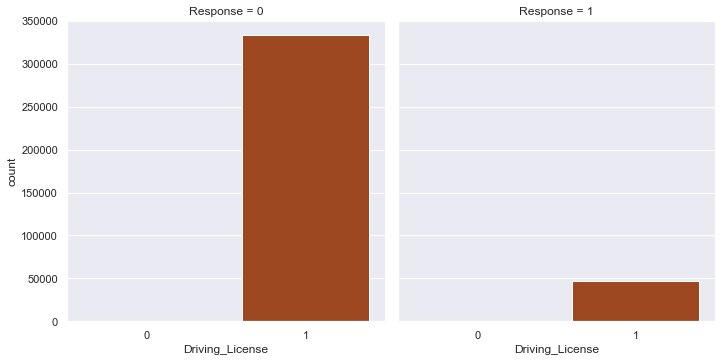

In [69]:
sns.catplot(x="Driving_License", 
            col="Response", 
            data=df_train, 
            kind="count")

In [70]:
df_train.groupby(["Driving_License", "Response"]).size().unstack()

Response,0,1
Driving_License,,
0,771,41
1,333628,46669


##### Region Code and Response

Text(0.5, 1.0, 'Correlation between Region code and Response')

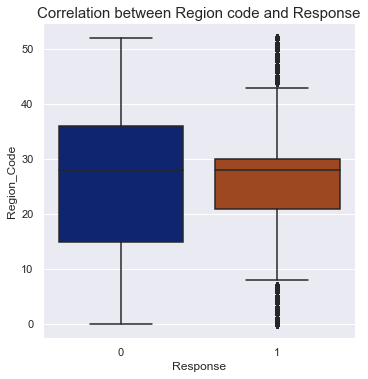

In [71]:
sns.catplot(x="Response", 
            y="Region_Code", 
            data=df_train, 
            kind="box")
plt.title("Correlation between Region code and Response", size=15, y=1.0)

<AxesSubplot:xlabel='Region_Code', ylabel='Density'>

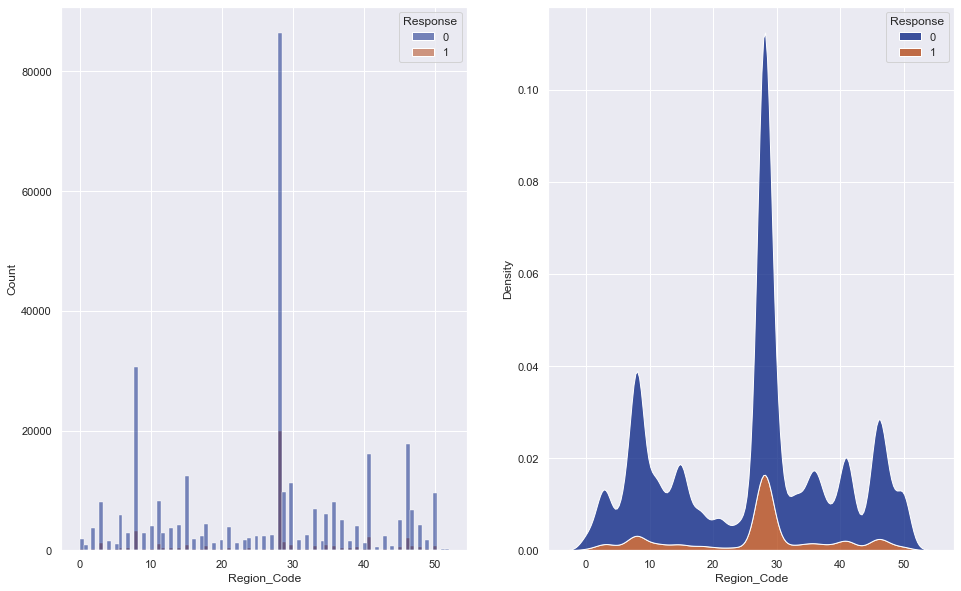

In [72]:
plt.subplot(1, 2, 1)
sns.histplot(x="Region_Code", data=df_train, hue="Response")

plt.subplot(1, 2, 2)
sns.kdeplot(x="Region_Code", data=df_train, hue="Response", multiple="stack")

##### Vehicle Damage and Vehicle Age

<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

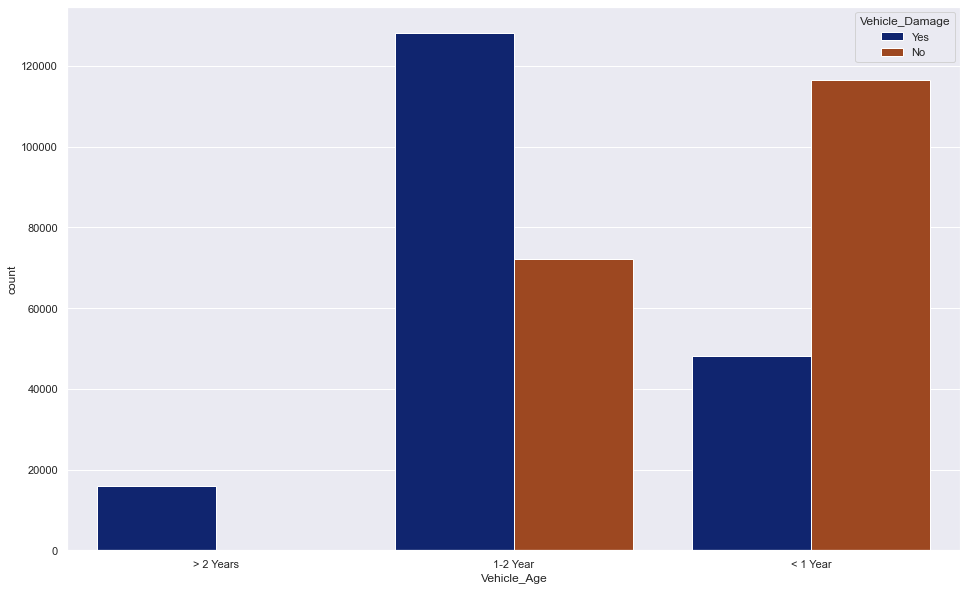

In [73]:
sns.countplot(data=df_train,
              x='Vehicle_Age',
              hue='Vehicle_Damage')

##### Age and Vehicle Annual_Premium

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='Annual_Premium'>

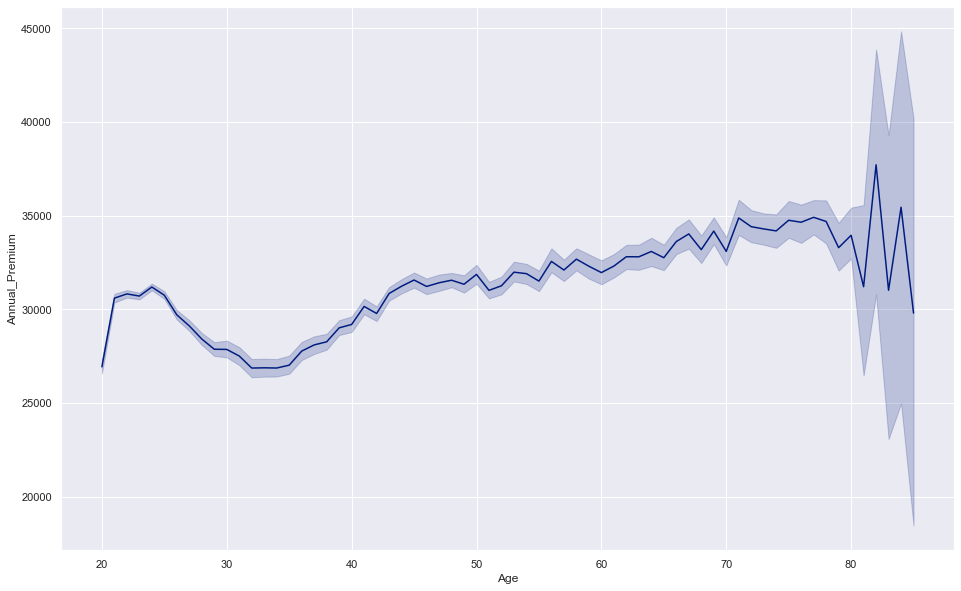

In [74]:
sns.lineplot(df_train["Age"],
             df_train["Annual_Premium"])

##### Previously_Insured and Vehicle_Age

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

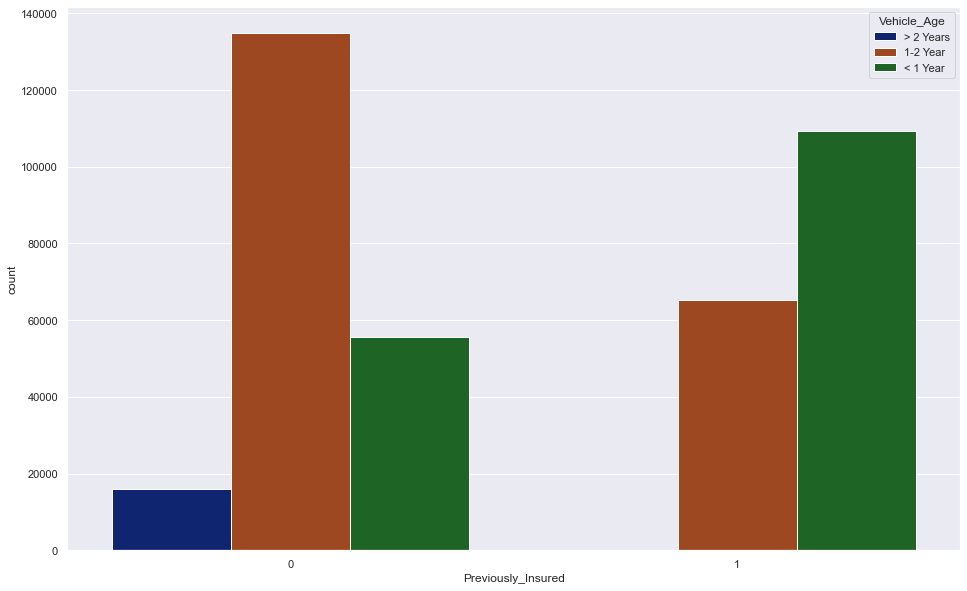

In [75]:
sns.countplot(df_train["Previously_Insured"],
              hue=df_train["Vehicle_Age"])

#### Correlation matrix.

<AxesSubplot:>

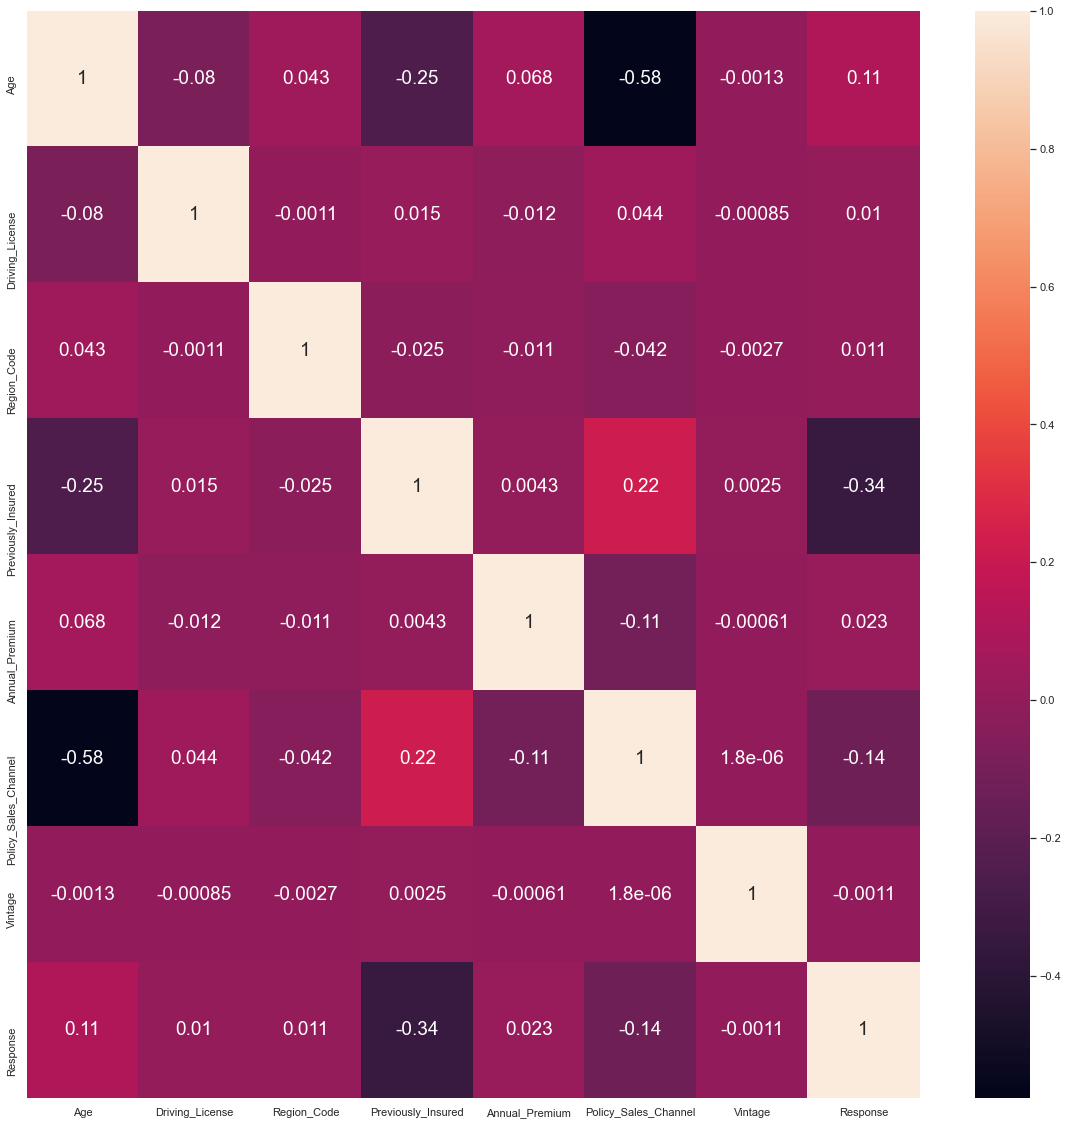

In [76]:
plt.figure(figsize=(20,20))
sns.heatmap(df_train.corr(), annot=True, annot_kws={"size":19})

In [77]:
# if "Vehicle Damage" not in heatmap:
# restart the cells (previous and next)

In [78]:
correlation = df_train.corr()
correlation["Response"].sort_values(ascending = False)[1:]

Age                     0.111147
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
Name: Response, dtype: float64

### Data preprocessing

#### Scaling

In [79]:
# Train df
num_columns = ['Age', 'Annual_Premium', 'Vintage']

ss= StandardScaler()
ss.fit(df_train[num_columns])

df_train[num_columns] = ss.transform(df_train[num_columns])

df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,0.333777,1,28.0,0,> 2 Years,Yes,0.574539,26.0,0.748795,1
1,Male,2.396751,1,3.0,0,1-2 Year,No,0.172636,26.0,0.342443,0
2,Male,0.527181,1,28.0,0,> 2 Years,Yes,0.449053,26.0,-1.521998,1
3,Male,-1.148985,1,11.0,1,< 1 Year,No,-0.113018,152.0,0.581474,0
4,Female,-0.633242,1,41.0,1,< 1 Year,No,-0.178259,152.0,-1.378580,0


In [80]:
# Test df
num_columns = ['Age', 'Annual_Premium', 'Vintage']

ss= StandardScaler()
ss.fit(dataset_test[num_columns])

dataset_test[num_columns] = ss.transform(dataset_test[num_columns])

dataset_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,-0.890089,1,11.0,1,< 1 Year,No,0.310492,152.0,-1.211054
1,381111,Male,0.079795,1,28.0,0,1-2 Year,Yes,0.191048,7.0,-0.517782
2,381112,Male,0.532408,1,28.0,0,1-2 Year,Yes,0.562126,124.0,0.534079
3,381113,Male,-0.954748,1,27.0,1,< 1 Year,Yes,0.403143,152.0,0.390643
4,381114,Male,-0.760771,1,28.0,1,< 1 Year,No,1.686159,152.0,1.705469


#### One-Hot Encoding with Pandas (get_dummies)

In [81]:
# Train df
df_train = pd.get_dummies(df_train, columns=["Gender", "Previously_Insured",
                                             "Driving_License", "Vehicle_Damage", "Vehicle_Age"],
                         drop_first=True)
df_train.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Previously_Insured_1,Driving_License_1,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,0.333777,28.0,0.574539,26.0,0.748795,1,1,0,1,1,0,1
1,2.396751,3.0,0.172636,26.0,0.342443,0,1,0,1,0,0,0
2,0.527181,28.0,0.449053,26.0,-1.521998,1,1,0,1,1,0,1
3,-1.148985,11.0,-0.113018,152.0,0.581474,0,1,1,1,0,1,0
4,-0.633242,41.0,-0.178259,152.0,-1.378580,0,0,1,1,0,1,0


In [82]:
df_train.shape

(381109, 12)

In [83]:
# Test df
dataset_test = pd.get_dummies(dataset_test, columns=["Gender", "Previously_Insured",
                                             "Driving_License", "Vehicle_Damage", "Vehicle_Age"],
                         drop_first=True)
dataset_test.head()

,id,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Previously_Insured_1,Driving_License_1,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,381110,-0.890089,11.0,0.310492,152.0,-1.211054,1,1,1,0,1,0
1,381111,0.079795,28.0,0.191048,7.0,-0.517782,1,0,1,1,0,0
2,381112,0.532408,28.0,0.562126,124.0,0.534079,1,0,1,1,0,0
3,381113,-0.954748,27.0,0.403143,152.0,0.390643,1,1,1,1,1,0
4,381114,-0.760771,28.0,1.686159,152.0,1.705469,1,1,1,0,1,0


In [84]:
dataset_test.shape

(127037, 12)

#### Target Encoder with Sklearn

In [85]:
# Train df
df_train["Region_Code"] = df_train["Region_Code"].map(str)
df_train["Policy_Sales_Channel"] = df_train["Policy_Sales_Channel"].map(str)

In [86]:
# Test df
dataset_test["Region_Code"] = dataset_test["Region_Code"].map(str)
dataset_test["Policy_Sales_Channel"] = dataset_test["Policy_Sales_Channel"].map(str)

In [87]:
encoder = TargetEncoder()

df_train["Region_Code_sklearn"] = encoder.fit_transform(df_train['Region_Code'], df_train['Response'])
dataset_test["Region_Code_sklearn"] = encoder.transform(dataset_test['Region_Code'])

C:\Users\Gcarl\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\Gcarl\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [88]:
encoder = TargetEncoder()

df_train["Policy_Sales_Channel_sklearn"] = encoder.fit_transform(df_train['Policy_Sales_Channel'], df_train['Response'])
dataset_test["Policy_Sales_Channel_sklearn"] = encoder.transform(dataset_test['Policy_Sales_Channel'])

C:\Users\Gcarl\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\Gcarl\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [89]:
df_train.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Previously_Insured_1,Driving_License_1,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Region_Code_sklearn,Policy_Sales_Channel_sklearn
0,0.333777,28.0,0.574539,26.0,0.748795,1,1,0,1,1,0,1,0.187163,0.199385
1,2.396751,3.0,0.172636,26.0,0.342443,0,1,0,1,0,0,0,0.127662,0.199385
2,0.527181,28.0,0.449053,26.0,-1.521998,1,1,0,1,1,0,1,0.187163,0.199385
3,-1.148985,11.0,-0.113018,152.0,0.581474,0,1,1,1,0,1,0,0.112760,0.028624
4,-0.633242,41.0,-0.178259,152.0,-1.378580,0,0,1,1,0,1,0,0.121776,0.028624


In [90]:
dataset_test.head()

,id,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Previously_Insured_1,Driving_License_1,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Region_Code_sklearn,Policy_Sales_Channel_sklearn
0,381110,-0.890089,11.0,0.310492,152.0,-1.211054,1,1,1,0,1,0,0.112760,0.028624
1,381111,0.079795,28.0,0.191048,7.0,-0.517782,1,0,1,1,0,0,0.187163,0.113892
2,381112,0.532408,28.0,0.562126,124.0,0.534079,1,0,1,1,0,0,0.187163,0.189148
3,381113,-0.954748,27.0,0.403143,152.0,0.390643,1,1,1,1,1,0,0.074035,0.028624
4,381114,-0.760771,28.0,1.686159,152.0,1.705469,1,1,1,0,1,0,0.187163,0.028624


In [91]:
df_train.mean()

Age                            -9.258629e-16
Annual_Premium                 -5.018194e-16
Vintage                        -6.921441e-17
Response                        1.225634e-01
Gender_Male                     5.407613e-01
Previously_Insured_1            4.582101e-01
Driving_License_1               9.978694e-01
Vehicle_Damage_Yes              5.048766e-01
Vehicle_Age_< 1 Year            4.323855e-01
Vehicle_Age_> 2 Years           4.200111e-02
Region_Code_sklearn             1.225634e-01
Policy_Sales_Channel_sklearn    1.225615e-01
dtype: float64

In [92]:
df_train.std()

Age                             1.000001
Annual_Premium                  1.000001
Vintage                         1.000001
Response                        0.327936
Gender_Male                     0.498336
Previously_Insured_1            0.498251
Driving_License_1               0.046110
Vehicle_Damage_Yes              0.499977
Vehicle_Age_< 1 Year            0.495408
Vehicle_Age_> 2 Years           0.200592
Region_Code_sklearn             0.045286
Policy_Sales_Channel_sklearn    0.086360
dtype: float64

### Functions to evaluate models

In [93]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=False):

    cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp 

    df_cm = pd.DataFrame(cm, index = labels, 
                        columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    sns.heatmap(df_cm, annot=True, fmt="g")

    if show_precision_recall:
    # Quale percentuale di classificazione positive sono effettivamente positive?
        plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
    # Quale percentuale di osservazioni positive sono state classificate come positive?
        plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")

In [94]:
def predict_and_plot(inputs, targets,name=''):
    preds=lr.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));    
    return preds

### Models definition

In [95]:
X = df_train.drop(["Response", "Region_Code", "Policy_Sales_Channel"], axis=1).values
y = df_train["Response"].values

print(X.shape)
print(y.shape)

(381109, 11)
(381109,)


#### Model 1: simple logistic regression

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state= SEED)

lr = LogisticRegression(max_iter=700)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=700)

##### Model 1 evaluation

In [97]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    233887
           1       0.34      0.01      0.01     32889

    accuracy                           0.88    266776
   macro avg       0.61      0.50      0.47    266776
weighted avg       0.81      0.88      0.82    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100512
           1       0.40      0.01      0.01     13821

    accuracy                           0.88    114333
   macro avg       0.64      0.50      0.47    114333
weighted avg       0.82      0.88      0.82    114333



##### Train confusion matrix

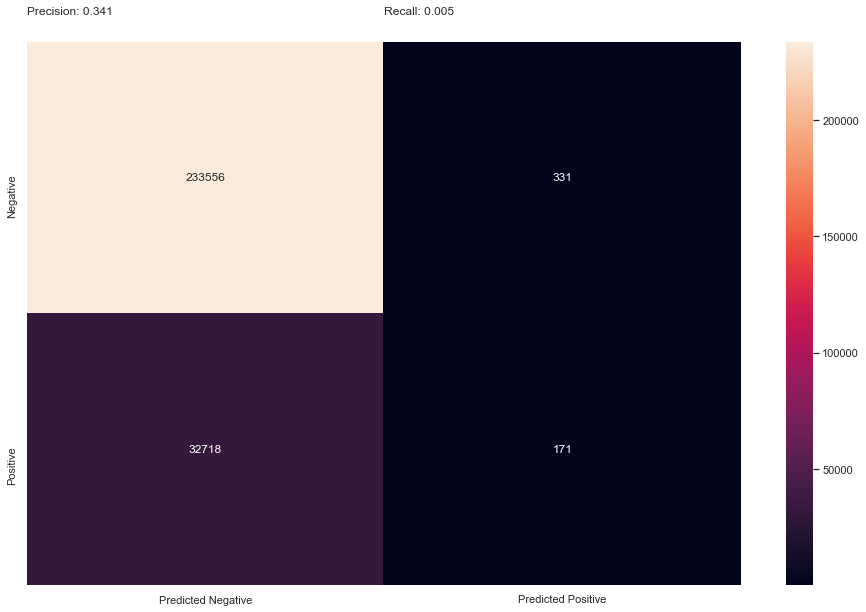

In [98]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

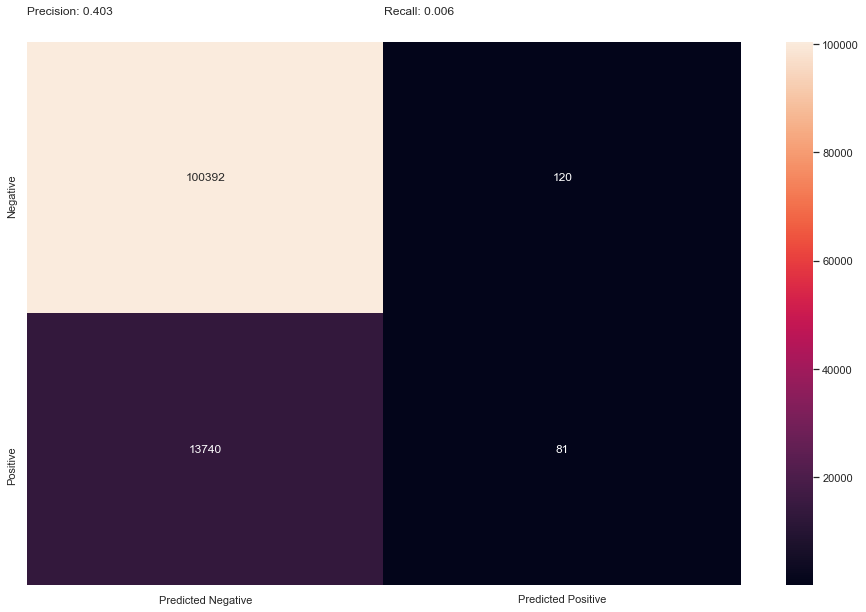

In [99]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 87.61%


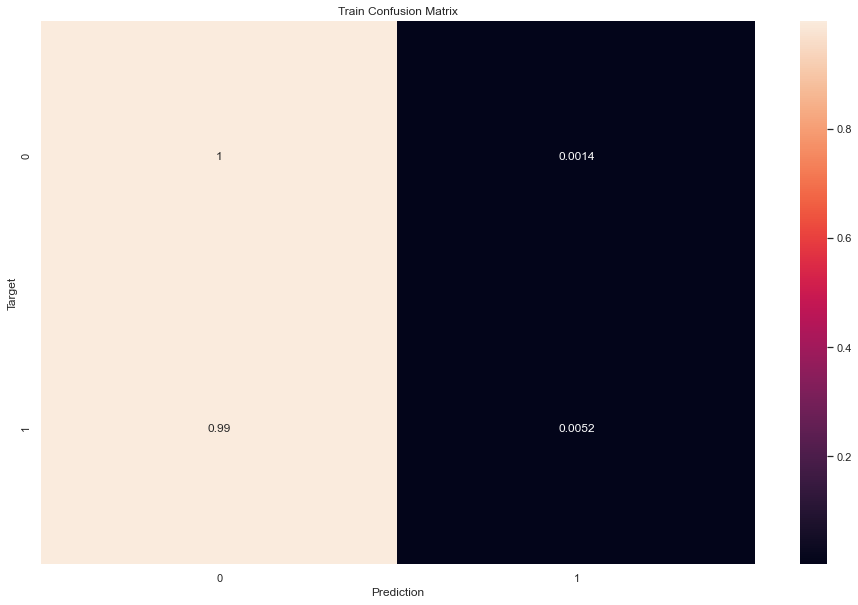

In [100]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 87.88%


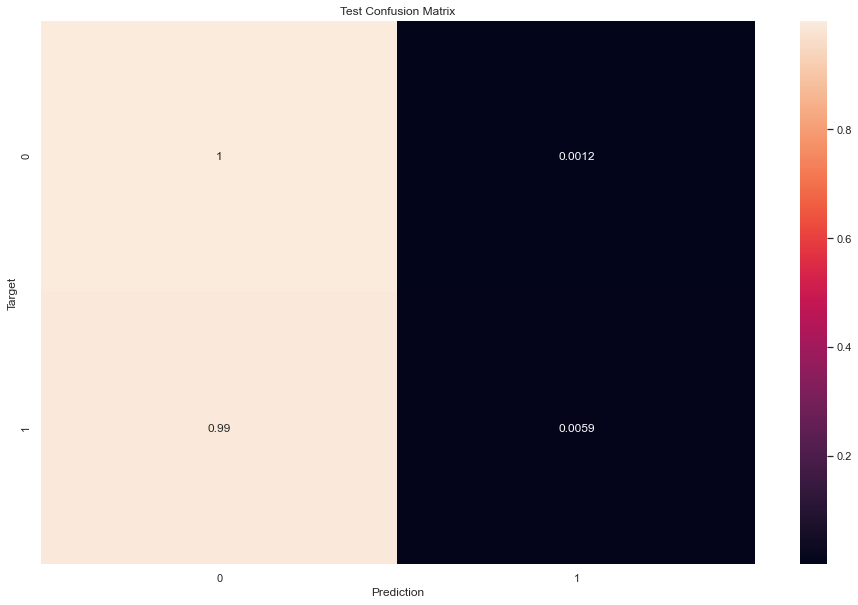

In [101]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

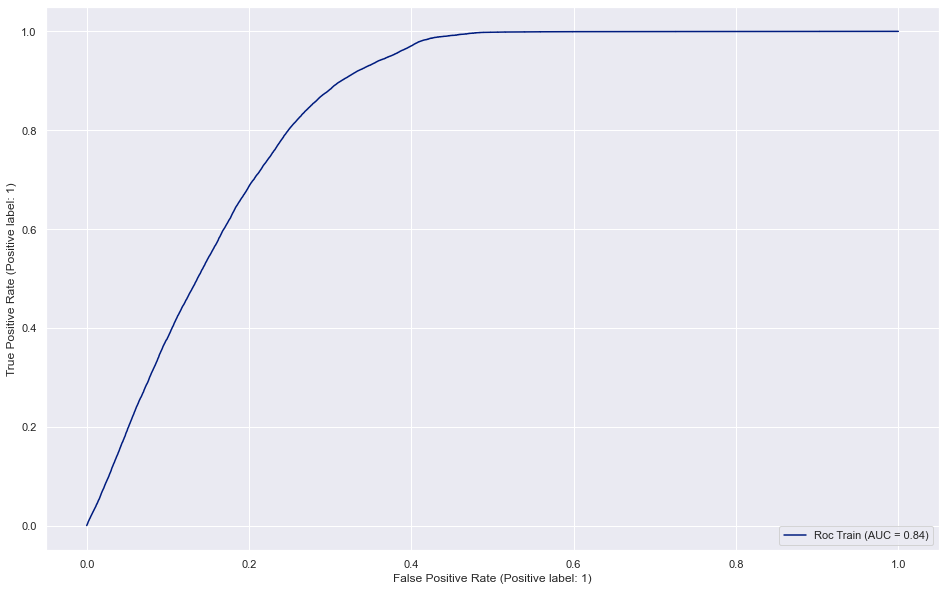

In [102]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

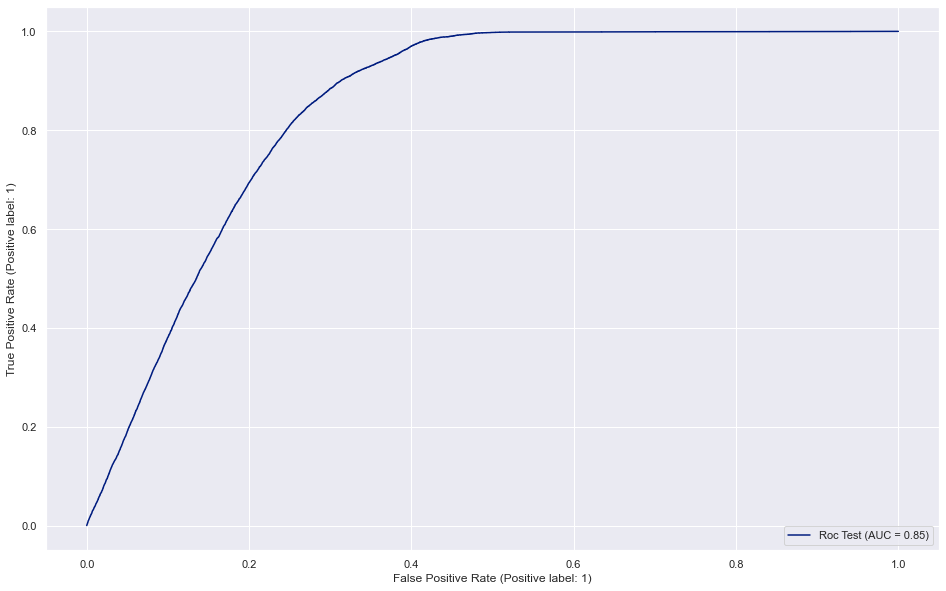

In [103]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

#### Model 2: logistic regression with class_weight = balanced

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state= SEED)

lr = LogisticRegression(max_iter=700, class_weight= "balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=700)

##### Model 2 evaluation

In [105]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

# for set threshold 0.4
y_pred_train = np.where(y_proba_train[:,1]>0.4, 1, 0)
y_pred_test = np.where(y_proba_test[:,1]>0.4, 1, 0)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233887
           1       0.25      0.98      0.40     32889

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100512
           1       0.25      0.98      0.40     13821

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



##### Train confusion matrix

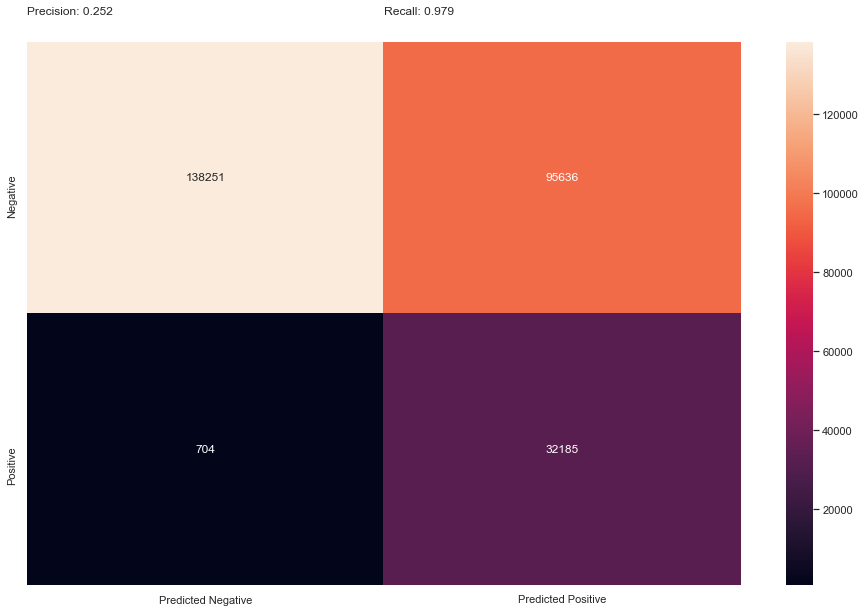

In [106]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

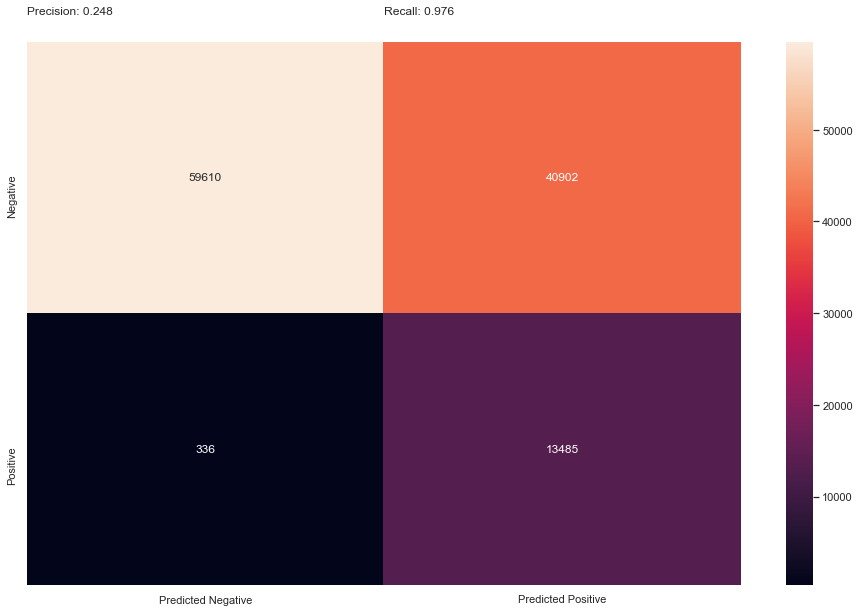

In [107]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 68.93%


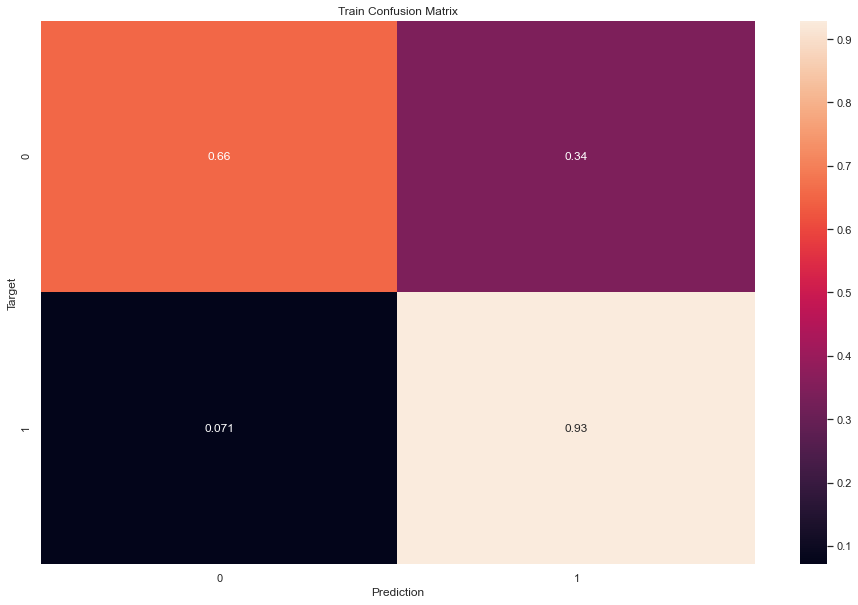

In [108]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 68.99%


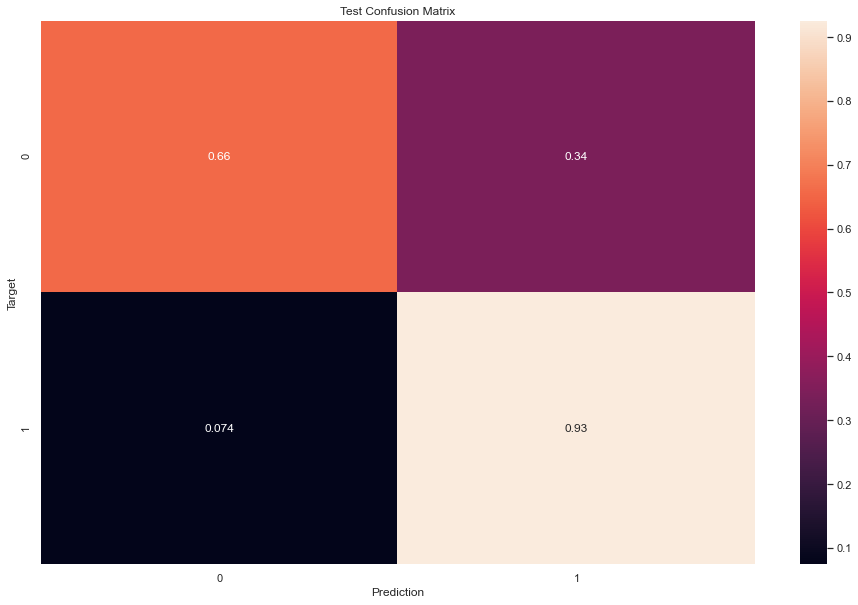

In [109]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

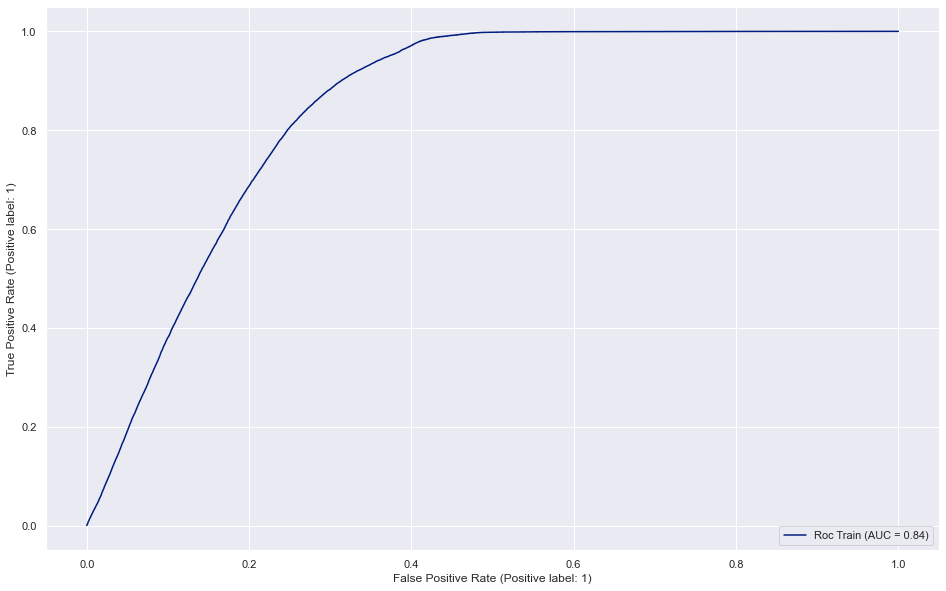

In [110]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

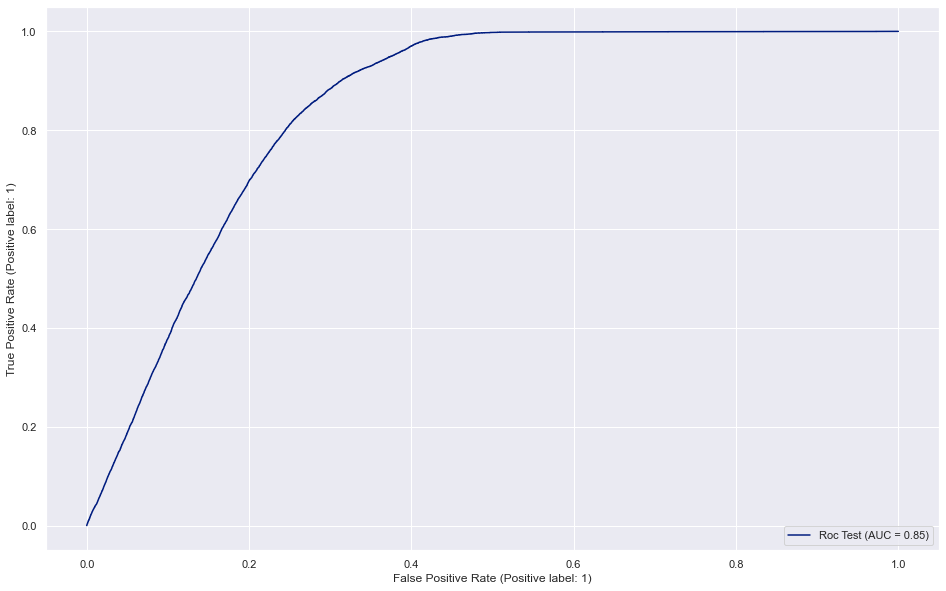

In [111]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

#### Model 3: logistic regression with Undersampling

In [112]:
rus = RandomUnderSampler(sampling_strategy = "majority", random_state=SEED)
X_res, y_res = rus.fit_resample(X, y)

print(X_res.shape)
print(y_res.shape)

(93420, 11)
(93420,)


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.3, random_state= SEED)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500)

##### Model 3 evaluation

In [114]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

# for set threshold 0.4
y_pred_train = np.where(y_proba_train[:,1]>0.4, 1, 0)
y_pred_test = np.where(y_proba_test[:,1]>0.4, 1, 0)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     32668
           1       0.71      0.98      0.82     32726

    accuracy                           0.79     65394
   macro avg       0.84      0.79      0.78     65394
weighted avg       0.84      0.79      0.78     65394

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     14042
           1       0.71      0.98      0.82     13984

    accuracy                           0.79     28026
   macro avg       0.84      0.79      0.78     28026
weighted avg       0.84      0.79      0.78     28026



##### Train confusion matrix

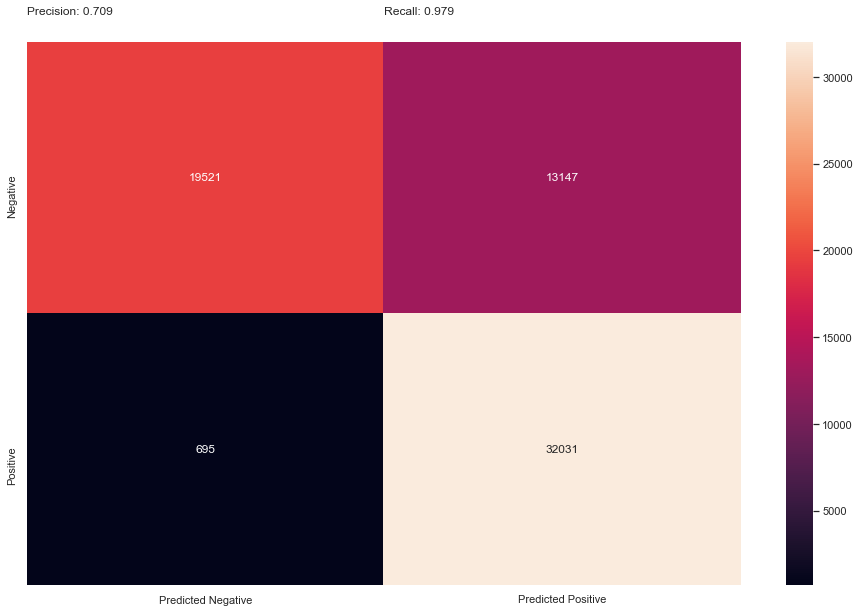

In [115]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

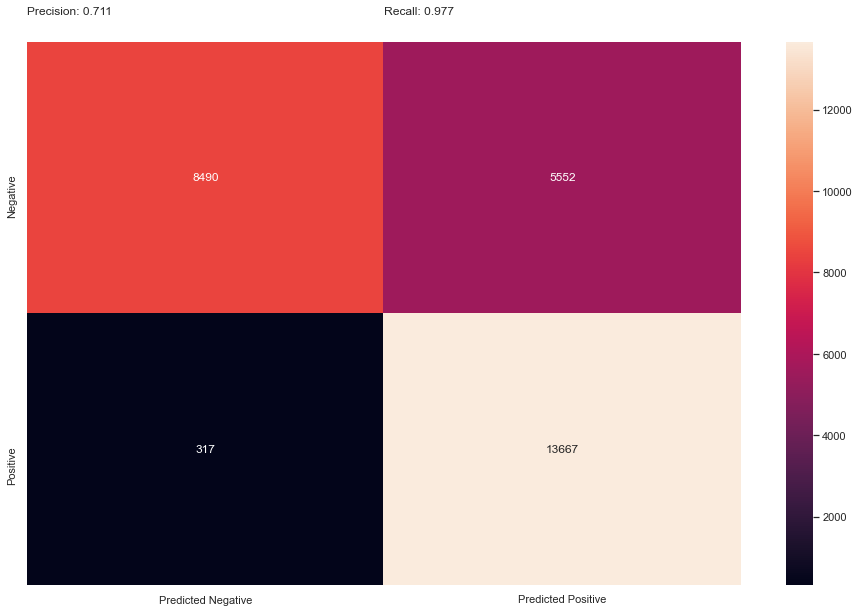

In [116]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 79.47%


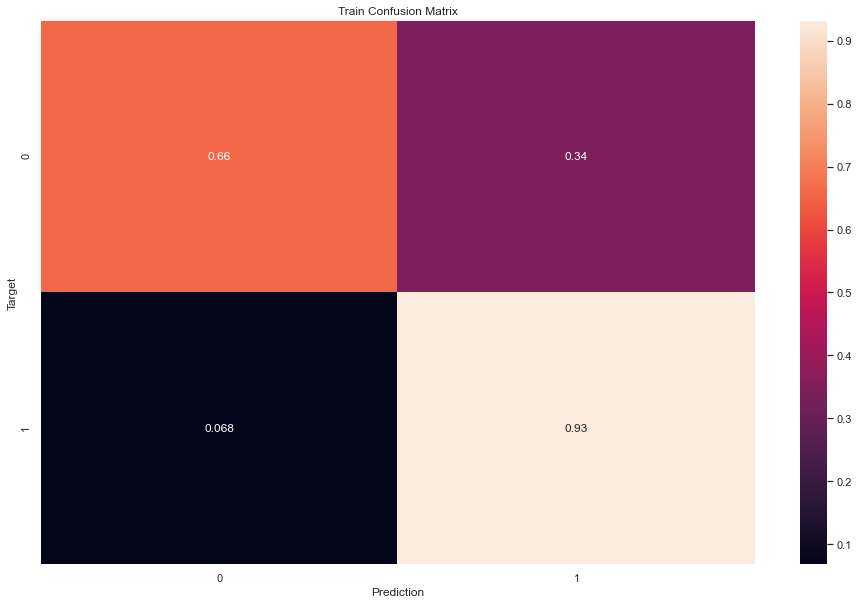

In [117]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 79.67%


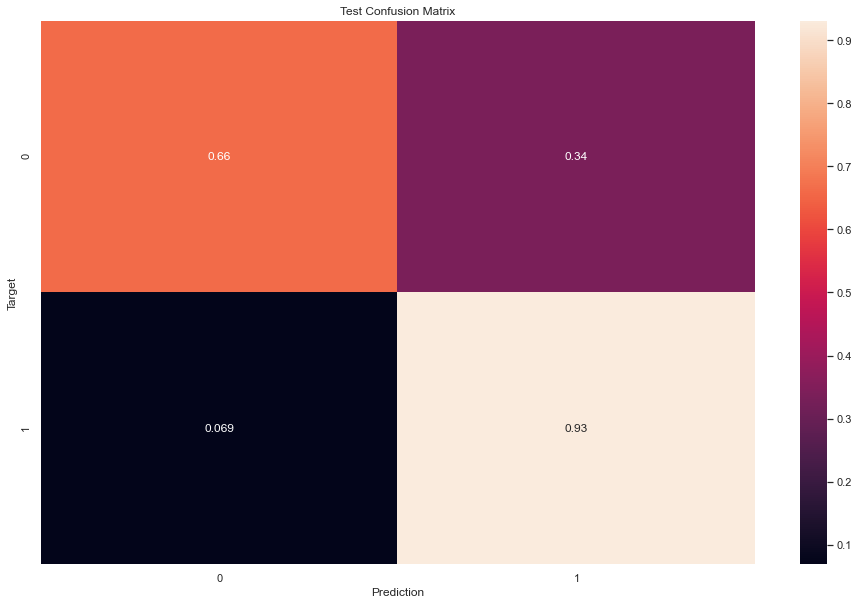

In [118]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

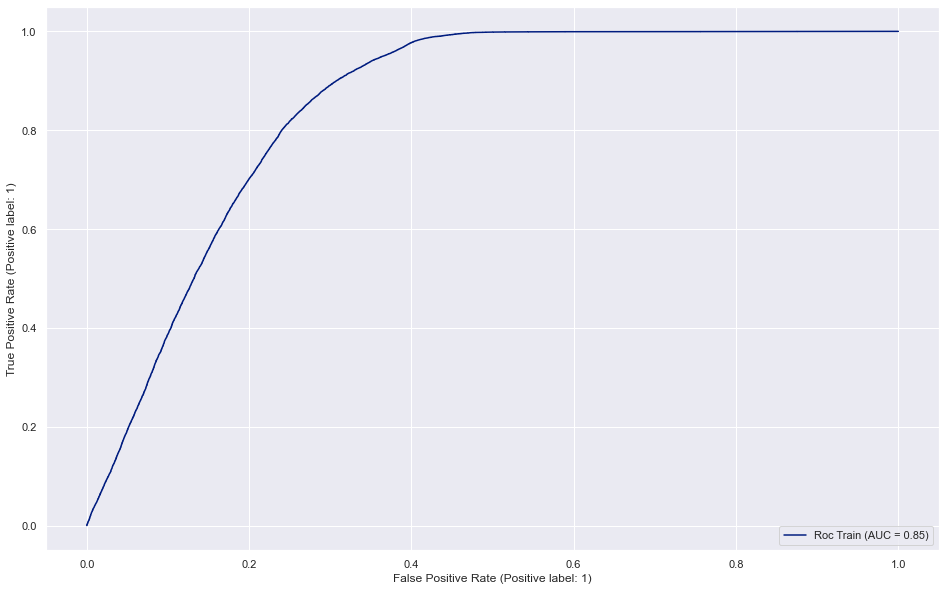

In [119]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

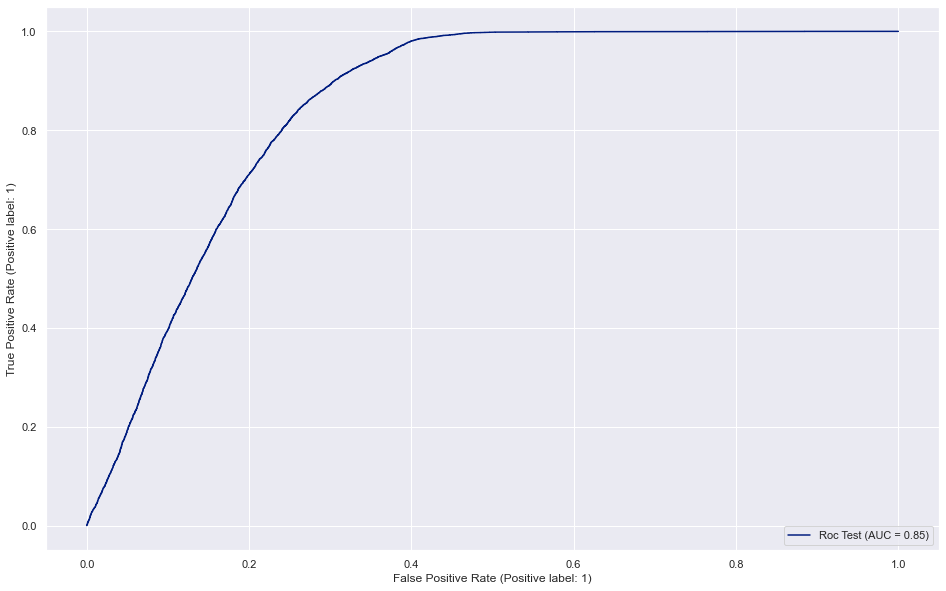

In [120]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

#### Model 4: logistic regression with Oversampling

In [121]:
ros = RandomOverSampler(sampling_strategy = "minority", random_state=SEED)
X_res, y_res = ros.fit_resample(X, y)

print(X_res.shape)
print(y_res.shape)

(668798, 11)
(668798,)


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.3, random_state= SEED)

lr = LogisticRegression(max_iter=600)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=600)

##### Model 4 evaluation

In [123]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

# for set threshold 0.4
y_pred_train = np.where(y_proba_train[:,1]>0.4, 1, 0)
y_pred_test = np.where(y_proba_test[:,1]>0.4, 1, 0)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234031
           1       0.71      0.98      0.82    234127

    accuracy                           0.78    468158
   macro avg       0.83      0.78      0.78    468158
weighted avg       0.83      0.78      0.78    468158

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    100368
           1       0.71      0.98      0.82    100272

    accuracy                           0.78    200640
   macro avg       0.83      0.79      0.78    200640
weighted avg       0.84      0.78      0.78    200640



##### Train confusion matrix

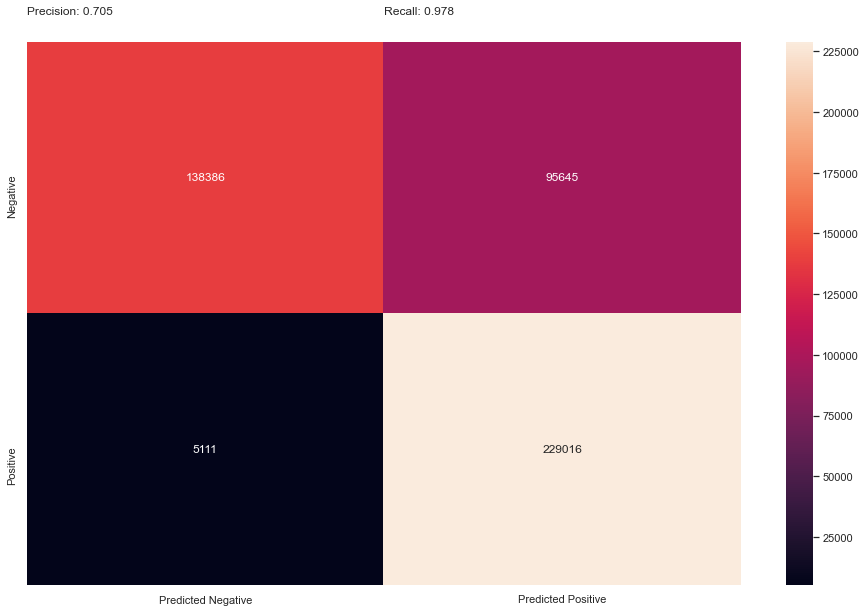

In [124]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

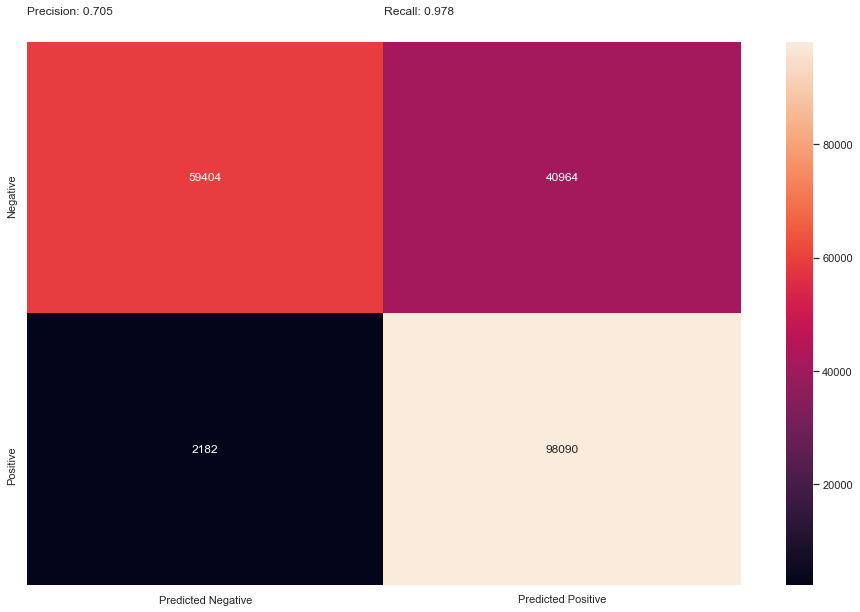

In [125]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 79.28%


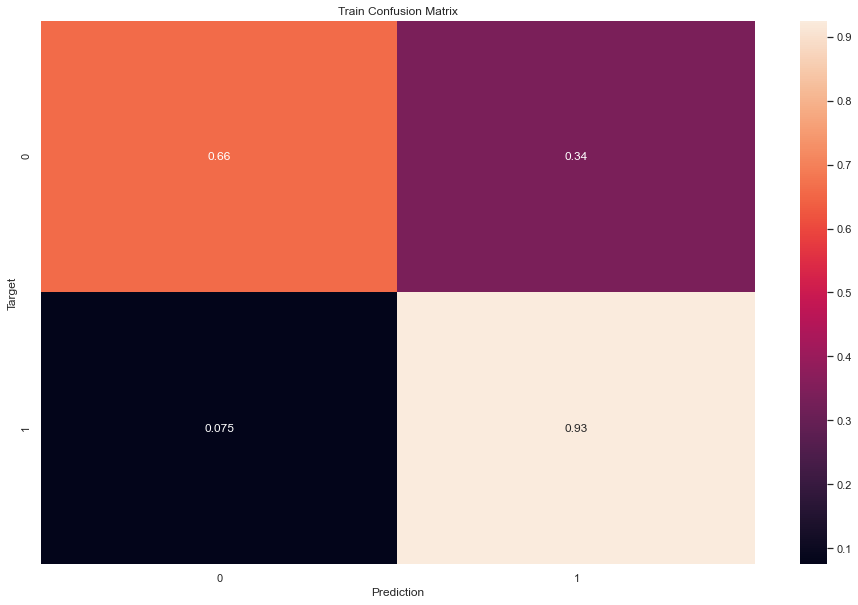

In [126]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 79.23%


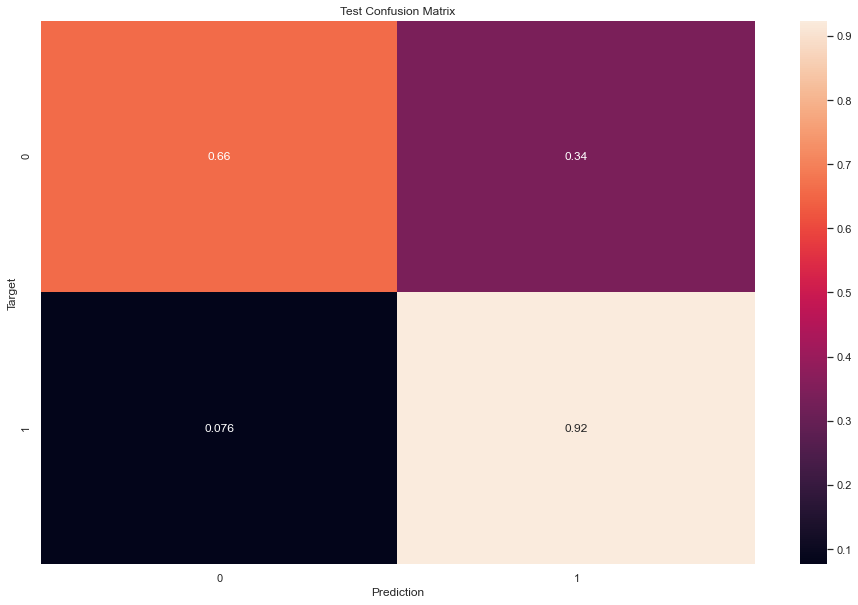

In [127]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

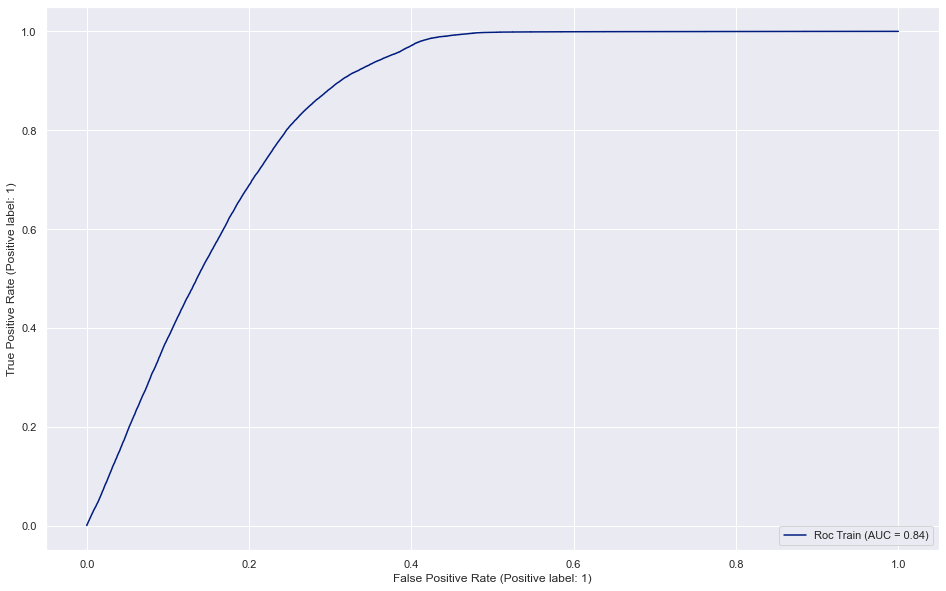

In [128]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

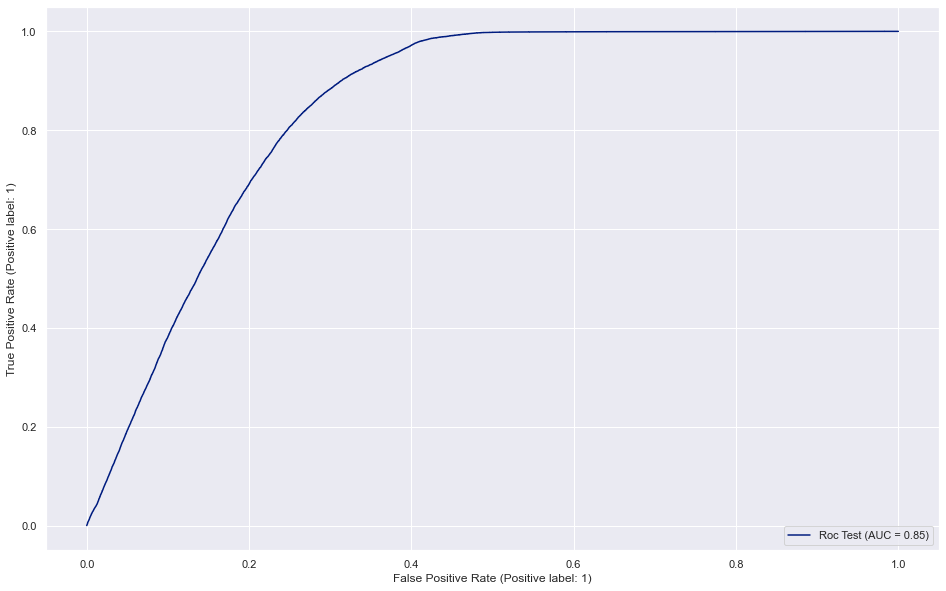

In [129]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

### Model definition without Region_Code_sklearn and Policy_Sales_Channel_sklearn

In [130]:
columns_to_remove = ["Response", "Region_Code", "Policy_Sales_Channel",
                     "Region_Code_sklearn","Policy_Sales_Channel_sklearn"]

X = df_train.drop(columns_to_remove, axis=1).values
y = df_train["Response"].values

print(X.shape)
print(y.shape)

(381109, 9)
(381109,)


#### Model 5: logistic regression with Undersampling

In [131]:
rus = RandomUnderSampler(sampling_strategy = "majority", random_state=SEED)
X_res, y_res = rus.fit_resample(X, y)

print(X_res.shape)
print(y_res.shape)

(93420, 9)
(93420,)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state= SEED)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

##### Model 5 evaluation

In [133]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

# for set threshold 0.4
y_pred_train = np.where(y_proba_train[:,1]>0.4, 1, 0)
y_pred_test = np.where(y_proba_test[:,1]>0.4, 1, 0)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     37324
           1       0.71      0.98      0.82     37412

    accuracy                           0.79     74736
   macro avg       0.84      0.79      0.78     74736
weighted avg       0.84      0.79      0.78     74736

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      9386
           1       0.71      0.97      0.82      9298

    accuracy                           0.79     18684
   macro avg       0.83      0.79      0.78     18684
weighted avg       0.83      0.79      0.78     18684



##### Train confusion matrix

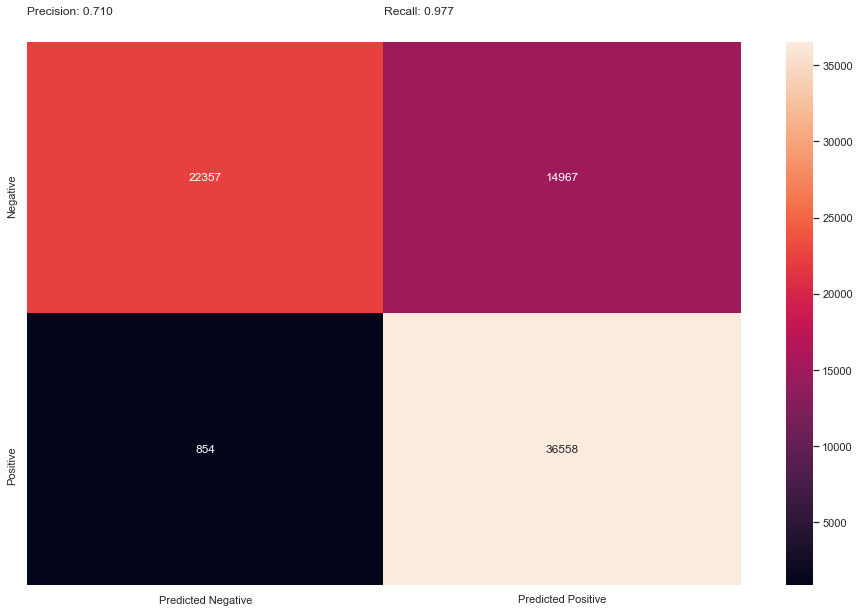

In [134]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

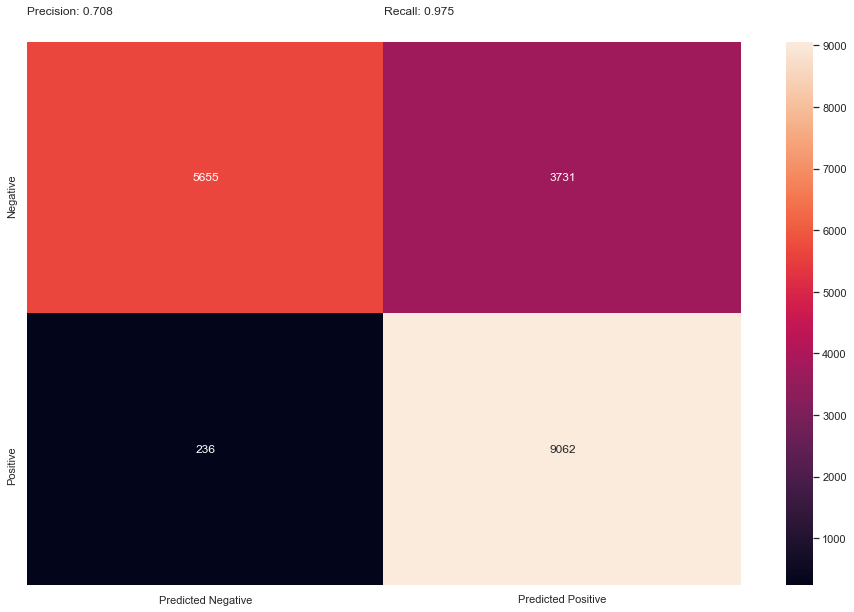

In [135]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 78.72%


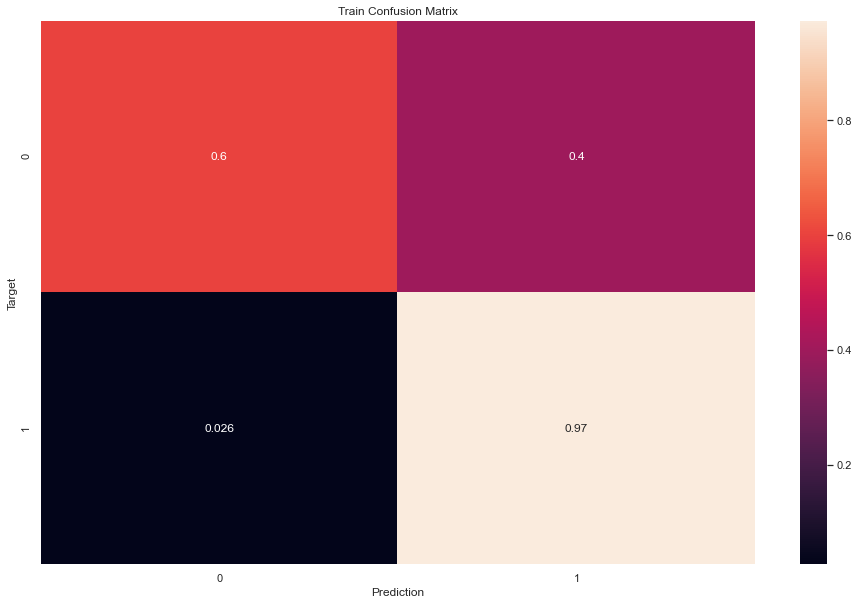

In [136]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 78.69%


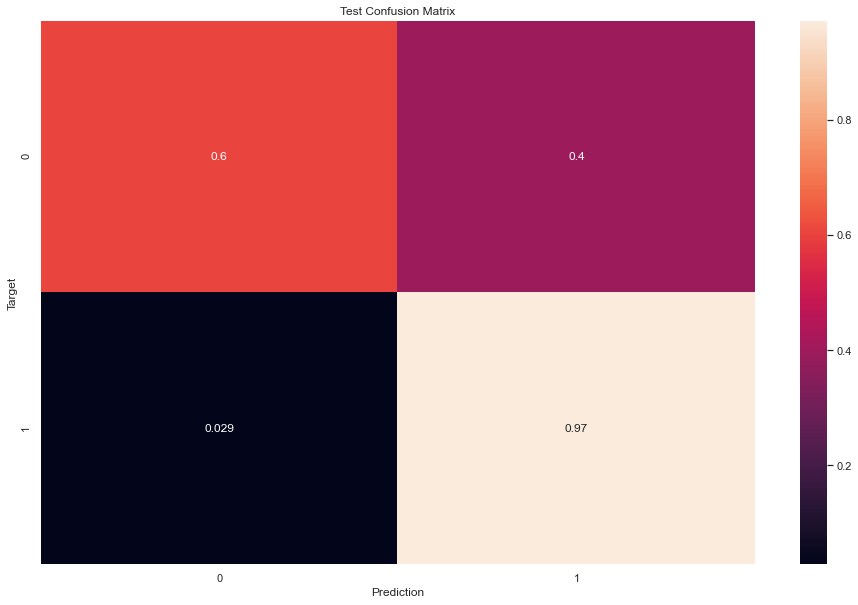

In [137]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

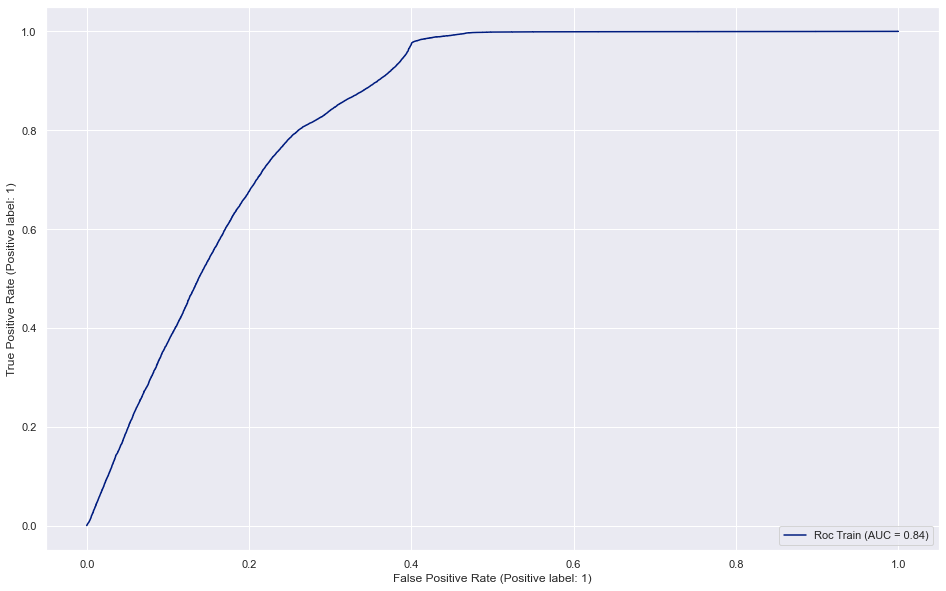

In [138]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

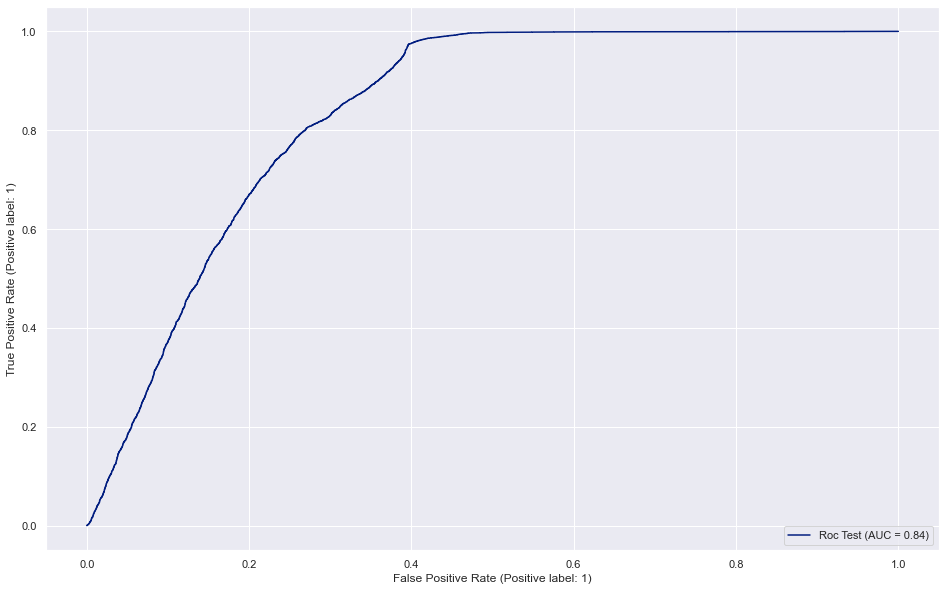

In [139]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

#### Model 6: logistic regression with Oversampling

In [140]:
ros = RandomOverSampler(sampling_strategy = "minority", random_state=SEED)
X_res, y_res = ros.fit_resample(X, y)

print(X_res.shape)
print(y_res.shape)

(668798, 9)
(668798,)


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.3, random_state= SEED)

lr = LogisticRegression(max_iter=600)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=600)

##### Model 6 evaluation

In [142]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

# for set threshold 0.4
y_pred_train = np.where(y_proba_train[:,1]>0.4, 1, 0)
y_pred_test = np.where(y_proba_test[:,1]>0.4, 1, 0)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234031
           1       0.71      0.98      0.82    234127

    accuracy                           0.78    468158
   macro avg       0.83      0.78      0.78    468158
weighted avg       0.83      0.78      0.78    468158

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    100368
           1       0.71      0.98      0.82    100272

    accuracy                           0.78    200640
   macro avg       0.83      0.78      0.78    200640
weighted avg       0.83      0.78      0.78    200640



##### Train confusion matrix

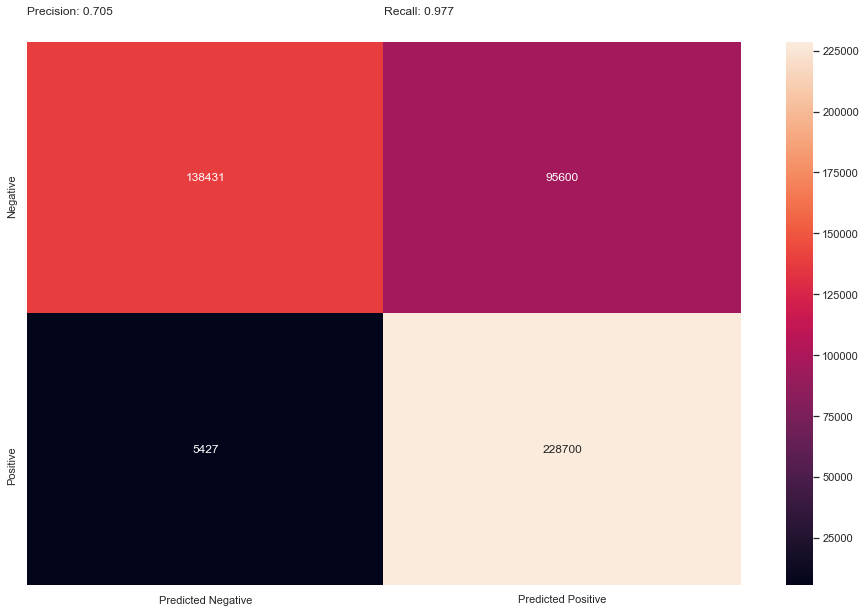

In [143]:
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

##### Test confusion matrix

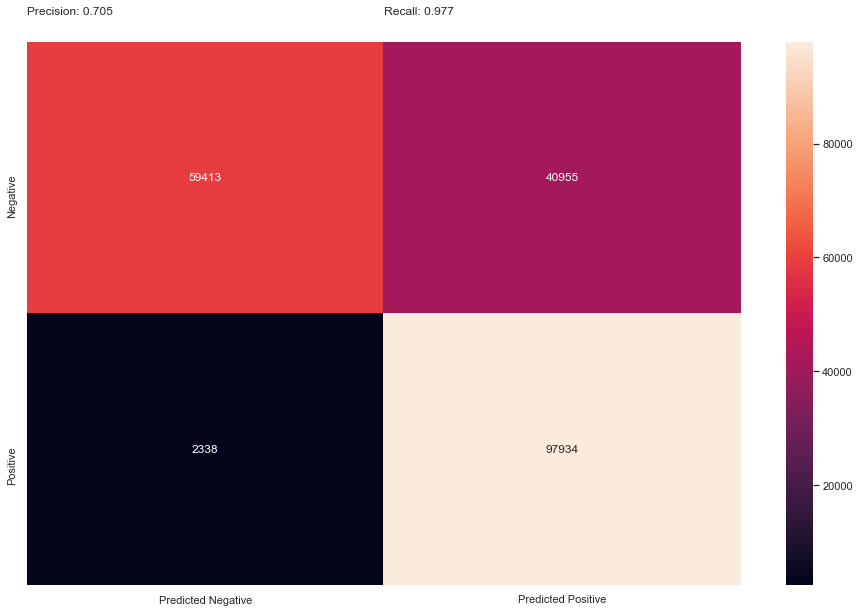

In [144]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

##### Train: Plot and prediction

Accuracy: 78.29%


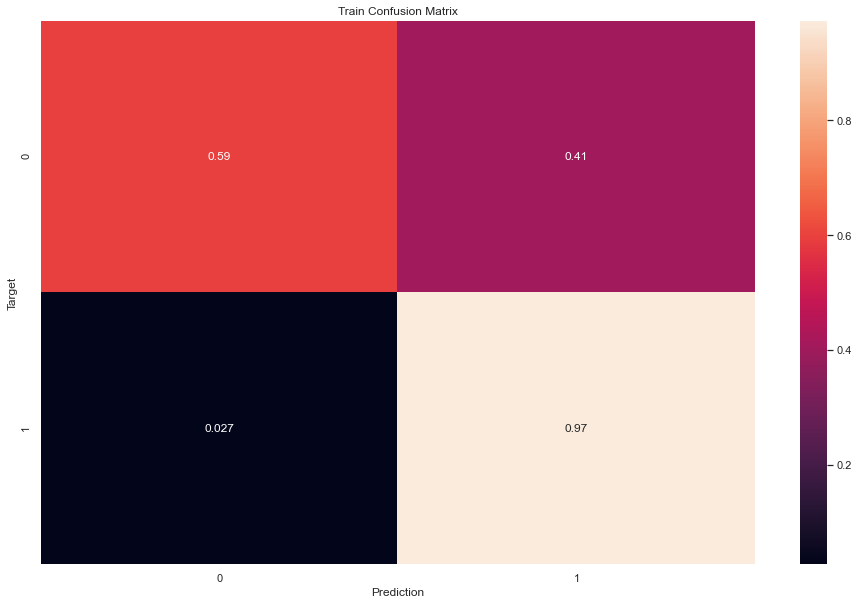

In [145]:
train_preds=predict_and_plot(X_train, y_train,'Train')

##### Test: Plot and prediction

Accuracy: 78.29%


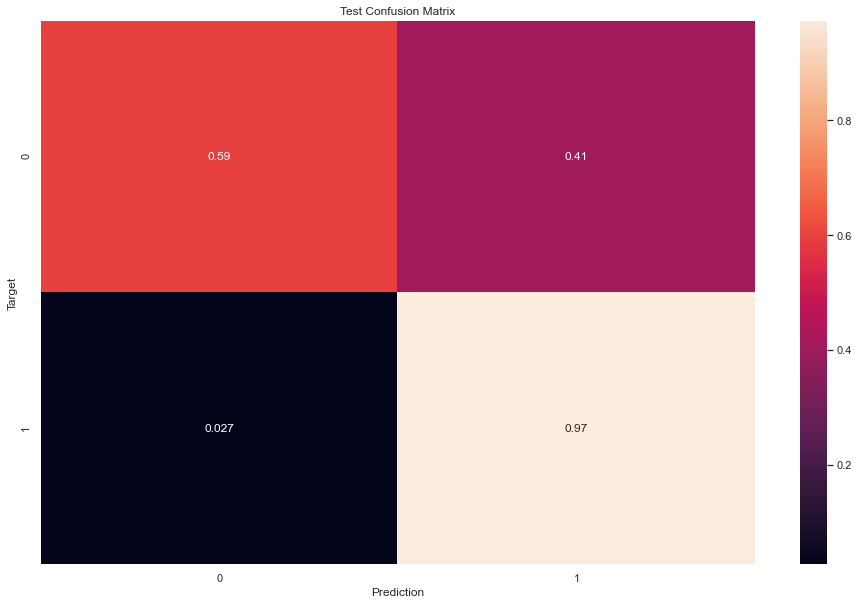

In [146]:
train_preds=predict_and_plot(X_test, y_test,'Test')

##### Train: Plot roc curve

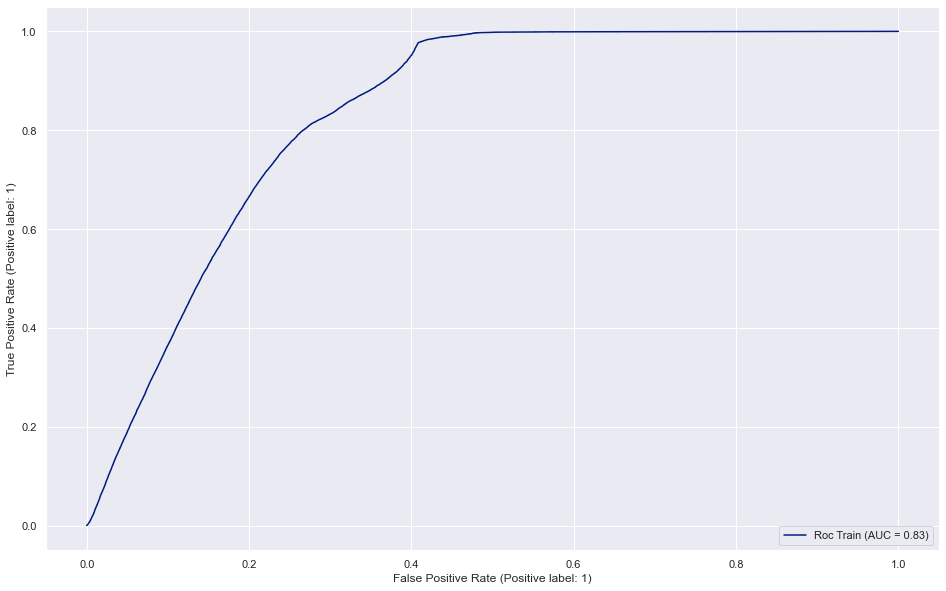

In [147]:
plot_roc_curve(lr, X_train, y_train, name="Roc Train")

##### Test: Plot roc curve

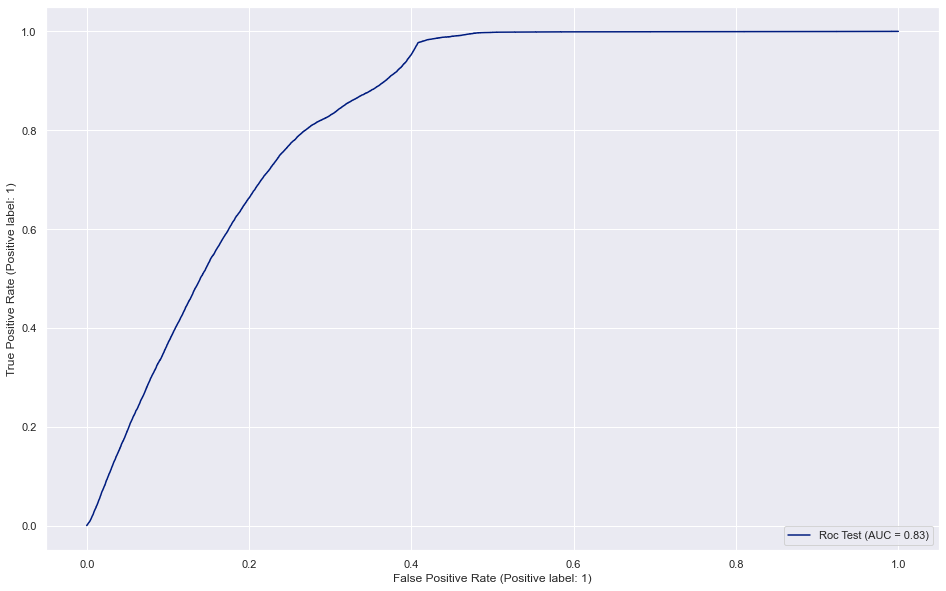

In [148]:
plot_roc_curve(lr, X_test, y_test, name="Roc Test")

### Complete model for forecasting

#### Best model: 3 logistic regression with Undersampling

In [149]:
X = df_train.drop(["Response", "Region_Code", "Policy_Sales_Channel"], axis=1).values
y = df_train["Response"].values

print(X.shape)
print(y.shape)

(381109, 11)
(381109,)


In [150]:
df_train

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Previously_Insured_1,Driving_License_1,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Region_Code_sklearn,Policy_Sales_Channel_sklearn
0,0.333777,28.0,0.574539,26.0,0.748795,1,1,0,1,1,0,1,0.187163,0.199385
1,2.396751,3.0,0.172636,26.0,0.342443,0,1,0,1,0,0,0,0.127662,0.199385
2,0.527181,28.0,0.449053,26.0,-1.521998,1,1,0,1,1,0,1,0.187163,0.199385
3,-1.148985,11.0,-0.113018,152.0,0.581474,0,1,1,1,0,1,0,0.112760,0.028624
4,-0.633242,41.0,-0.178259,152.0,-1.378580,0,0,1,1,0,1,0,0.121776,0.028624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,2.267815,26.0,-0.022912,26.0,-0.792954,0,1,1,1,0,0,0,0.072284,0.199385
381105,-0.568774,37.0,0.549093,152.0,-0.279037,0,1,1,1,0,1,0,0.079258,0.028624
381106,-1.148985,30.0,0.264543,160.0,0.079509,0,1,1,1,0,1,0,0.073825,0.021810
381107,1.881007,14.0,0.816389,124.0,-0.960275,0,0,0,1,1,0,1,0.090209,0.189148


In [151]:
rus = RandomUnderSampler(sampling_strategy = "majority", random_state=SEED)
X_res, y_res = rus.fit_resample(X, y)

print(X_res.shape)
print(y_res.shape)

(93420, 11)
(93420,)


In [152]:
model = LogisticRegression(max_iter=500)
model.fit(X_res, y_res)

LogisticRegression(max_iter=500)

In [153]:
cols_to_drop = ["id", "Region_Code", "Policy_Sales_Channel"]

X = dataset_test.drop(cols_to_drop, axis=1).values

y_proba = model.predict_proba(X)
y_pred = np.where(y_proba[:,1]>0.4,1,0)

In [154]:
df_result = pd.DataFrame({
    "id":dataset_test["id"],
    "Response":y_pred
})
df_result.head()

,id,Response
0,381110,0
1,381111,1
2,381112,1
3,381113,0
4,381114,0


In [155]:
df_result.to_excel("my_submission.xlsx", index=False)